In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
returns_dataframe = pd.read_pickle('Data/hml_df.pkl')
ls_returns = pd.DataFrame(returns_dataframe['hml_return'])

return_decomposition_df = pd.read_pickle('Data/return_decomposition_monthly.pkl')

interest_rates = pd.read_csv("Data/FEDFUNDS.csv", parse_dates=['observation_date'], index_col='observation_date')
gdp = pd.read_csv("Data/GDPC1.csv", parse_dates=['observation_date'], index_col='observation_date')
vix = pd.read_csv("Data/VIXCLS.csv", parse_dates=['observation_date'], index_col='observation_date')
inflation = pd.read_csv("Data/INFLATION.csv", parse_dates=["observation_date"], index_col="observation_date")
consumer_sentiment = pd.read_csv("Data/UMCSENT.csv", parse_dates=["observation_date"], index_col="observation_date")
credit_spread = pd.read_csv("Data/BAA10Y.csv", parse_dates=['observation_date'], index_col='observation_date')
TB = pd.read_csv("Data/DTB3.csv", parse_dates=['observation_date'], index_col='observation_date')
LGB = pd.read_csv("Data/LGB.csv", parse_dates=['observation_date'], index_col='observation_date')
industrial_production = pd.read_csv("Data/INDPRO.csv", parse_dates=['observation_date'], index_col='observation_date')
consumption = pd.read_csv("Data/PCE.csv", parse_dates=['observation_date'], index_col='observation_date')
oil_prices = pd.read_csv("Data/WPU0561.csv", parse_dates=['observation_date'], index_col='observation_date')
baa = pd.read_csv("Data/BAA.csv", parse_dates=['observation_date'], index_col='observation_date')
unemployment = pd.read_csv("Data/UNRATE.csv", parse_dates=['observation_date'], index_col='observation_date')
unemployment = unemployment/100
TB = TB/100
#inflation = inflation/100
baa = baa/100
LGB = LGB/100


interest_rates.rename(columns={"FEDFUNDS": "Interest_Rate"}, inplace=True)
gdp.rename(columns={"GDPC1": "Growth"}, inplace=True)
vix.rename(columns={"VIXCLS": "VIX"}, inplace=True)
inflation.rename(columns={"FPCPITOTLZGUSA": "Inflation"}, inplace=True)
#cpi = inflation_yearly.resample('M').ffill()
consumer_sentiment.rename(columns={"UMCSENT" : "Consumer_Sentiment"}, inplace=True)
credit_spread.rename(columns={"BAA10Y" : "Credit_Spread"}, inplace=True)
TB.rename(columns={"DTB3" : "Treasury Bill"}, inplace=True)
TB_shift = TB.shift(1)
LGB.rename(columns={"IRLTLT01USQ156N" : "LGB"}, inplace=True)
industrial_production.rename(columns={"INDPRO" : "Industrial_Production"}, inplace=True)
consumption.rename(columns={"PCE" : "Consumption"}, inplace=True)
oil_prices.rename(columns={"WPU0561" : "Oil_Prices"}, inplace=True)
ls_returns.index.name = "observation_date"

def to_month_end(df):
    # Wenn PeriodIndex: in Monatsende-DatetimeIndex umwandeln
    if isinstance(df.index, pd.PeriodIndex):
        df.index = df.index.to_timestamp('M')
    else:
        df.index = pd.to_datetime(df.index).to_period('M').to_timestamp('M')
    return df

ls_returns = to_month_end(ls_returns)
interest_rates = to_month_end(interest_rates)
gdp = to_month_end(gdp)
vix = to_month_end(vix)
vix = vix.groupby(vix.index).mean()
consumer_sentiment = to_month_end(consumer_sentiment)
TB = to_month_end(TB)
LGB = to_month_end(LGB)
industrial_production = to_month_end(industrial_production)
consumption = to_month_end(consumption)
oil_prices = to_month_end(oil_prices)
baa = to_month_end(baa)
inflation = to_month_end(inflation)
unemployment = to_month_end(unemployment)

# Ensure all are Series
TB_shift = TB_shift.squeeze()
LGB = LGB.squeeze()
baa = baa.squeeze()
inflation = inflation.squeeze()
industrial_production = industrial_production.squeeze()

TB_shift = TB_shift.asfreq('ME')
LGB = LGB.asfreq('ME')
baa = baa.asfreq('ME')
inflation = inflation.asfreq('ME')
industrial_production = industrial_production.asfreq('ME')

# Combine into one DataFrame using pd.concat
data = pd.concat(
    [TB_shift, LGB, baa, inflation, industrial_production, unemployment, ls_returns],
    axis=1,
    join='inner'
)

# Optional: assign column names if needed
data.columns = ['TB_shift', 'LGB', 'BAA', 'Inflation', 'IP', 'Unemployment', 'ls_returns']



In [4]:
return_decomposition_df

,hml_return,Migration_m,Income_Yield_m,CAV_m
date,,,,
1962-07-31,-0.008225,0.062145,-0.014308,-0.076091
1962-08-31,0.011839,0.067601,0.078872,0.001160
1962-09-30,0.018033,0.063809,0.078355,0.013332
1962-10-31,0.008743,0.062229,0.051059,0.007564
1962-11-30,-0.017226,0.062667,0.079983,0.003846
...,...,...,...,...
2018-02-28,-0.008893,0.032898,0.011505,0.004369
2018-03-31,0.006576,0.025629,0.103262,-0.044433
2018-04-30,0.012575,0.025704,0.062500,-0.012901


In [5]:
#Expected Inlfation
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

inflation_pct = inflation / 100
"""""
#Model fit
ar_order = [0,1,2,3,4,5, 6, 7]
i_order = [0,1,2,3,4,5]
ma_order = [0,1,2,3,4,5]
fit = []
for p in ar_order:
    for d in i_order:
        for q in ma_order:
            model = ARIMA(inflation_pct, order=(p, d, q))  # (p,d,q): AR, differenzieren, MA
            model_fit = model.fit()
            fit.append({"likelihood" : model_fit.llf, "P": p, "D" : d, "Q" : q})
best_model = max(fit, key=lambda x: x["likelihood"])

print("Bestes Modell:")
print(best_model)
"""
model = ARIMA(inflation_pct, order=(7,0,4)) #Orders derived from test
inflation_fit = model.fit(cov_type="robust")
print(inflation_fit.summary()) 

expected_inflation = inflation_fit.fittedvalues
expected_inflation

unexpected_inflation = inflation_pct - expected_inflation

                               SARIMAX Results                                
Dep. Variable:      MEDCPIM158SFRBCLE   No. Observations:                  508
Model:                 ARIMA(7, 0, 4)   Log Likelihood                1760.593
Date:                Wed, 09 Jul 2025   AIC                          -3495.187
Time:                        11:23:51   BIC                          -3440.191
Sample:                    01-31-1983   HQIC                         -3473.621
                         - 04-30-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0318      0.003      9.561      0.000       0.025       0.038
ar.L1          0.4197      0.301      1.396      0.163      -0.170       1.009
ar.L2          0.5895      0.295      1.999      0.0

In [20]:
#Derived Series
inflation = data.Inflation/100
#MP: Monthly growth (industrial production)
MP = np.log(data.IP) - np.log(data.IP.shift(1))

#YP: annual growth (industrial production)
YP = np.log(data.IP) - np.log(data.IP.shift(12))

#RHO: real interest (ex post)
#TB_shift, inflation = TB_shift.align(inflation, join='inner')
RHO = data.TB_shift - inflation

#DEI: Change in expected inflation
DEI = expected_inflation.shift(-1) - expected_inflation

#UPR: Rist premium
#baa, LGB = baa.align(LGB, join="inner")
URP = data.BAA - data.LGB

#UTS: Term structure
#LGB, TB_shift = LGB.align(TB_shift, join='inner')
UTS = data.LGB - data.TB_shift

MP = to_month_end(MP)
YP = to_month_end(YP)
RHO = to_month_end(RHO)
DEI = to_month_end(DEI)
URP = to_month_end(UPR)
UTS = to_month_end(UTS)
unexpected_inflation = to_month_end(unexpected_inflation)

# Deine Variablen (MP, YP, etc.) definieren

# Indizes ohne Duplikate (wie du schon machst)
RHO = RHO[~RHO.index.duplicated(keep='first')]
UTS = UTS[~UTS.index.duplicated(keep='first')]

# Gemeinsamen Index bestimmen, bei dem keine NaNs auftreten
common_index = MP.dropna().index
common_index = common_index.intersection(YP.dropna().index)
common_index = common_index.intersection(RHO.dropna().index)
common_index = common_index.intersection(DEI.dropna().index)
common_index = common_index.intersection(URP.dropna().index)
common_index = common_index.intersection(UTS.dropna().index)

# Zusammenführen nur auf gemeinsamen Index
#macros = pd.concat([df.loc[common_index] for df in [MP, YP, RHO, DEI, UPR, UTS]], axis=1)
#macros.columns = ['MP', 'YP', 'RHO', 'DEI', 'UPR', 'UTS']

#ls_returns.index = ls_returns.index.to_timestamp()
ls_returns.index = pd.to_datetime(ls_returns.index)
ls_returns.index = ls_returns.index.normalize()
#macros.index = macros.index.normalize()
#macros.index = macros.index.to_timestamp()
#common_index = ls_returns.index.intersection(macros.index)
#ls_returns = ls_returns.loc[common_index]
#macros = macros.loc[common_index]
#macros+
macro = pd.concat([MP, DEI, unexpected_inflation, UPR, UTS], axis=1, join='inner')
colnames= ['MP', 'DEI', 'UI', 'URP', 'UTS']
macro.columns = colnames
print(macro.head())
#pd.to_pickle(macro,'macro_us.pkl')

                        MP       DEI        UI     URP     UTS
observation_date                                              
1983-01-31             NaN  0.012921  0.018354  0.0322  0.0272
1983-02-28       -0.006123  0.001834  0.004812  0.0374  0.0239
1983-03-31        0.008274 -0.004335 -0.010425  0.0321  0.0177
1983-04-30        0.012581  0.001565  0.006068  0.0322     NaN
1983-05-31        0.006146 -0.001798 -0.006105  0.0246     NaN


VAR Model where the time series were derived from the paper of Nai-Fu Chen et al. (1986). To analyze the impact of one time series on the other, an impact response function was computed. The results show that a positive shock in the monthly change in production had a positive lagged (1) effect (0.45) on the portfolio returns. A positive shock in the unexpected inflation had a negative shock (-0.018), a positive shock in the risk premium did not have a significatn effect and the a positive shock in the term structure resulted in a positive effect (0.35) with a very slow decay. While the shocks from most of the time series reverted to zero within 10 periods, the show in the term structure did not.

In [23]:
from statsmodels.tsa.api import VAR

VAR_list = [ls_returns, MP, DEI, unexpected_inflation, UPR.diff(), UTS]
VAR_list = [squeeze if isinstance(squeeze, pd.Series) else squeeze.squeeze() for squeeze in VAR_list]

for s, name in zip(VAR_list, ['LSR','MP', 'DEI', 'UI', 'URP', 'UTS']):
    s.name = name

VAR_data = pd.concat(VAR_list, axis=1, join="inner").dropna()

model = VAR(VAR_data)
results = model.fit(maxlags=2, ic='aic')
print(results.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 09, Jul, 2025
Time:                     13:06:41
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -63.1358
Nobs:                     292.000    HQIC:                  -63.4528
Log likelihood:           6851.05    FPE:                2.24303e-28
AIC:                     -63.6646    Det(Omega_mle):     1.94583e-28
--------------------------------------------------------------------
Results for equation LSR
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.003860         0.003343           -1.155           0.248
L1.LSR         0.131481         0.058849            2.234           0.025
L1.MP          0.163634         0.239072            0.684           0.494
L1.DEI         1

/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [22]:
#Return Decomposition
from statsmodels.tsa.api import VAR
#Migration
VAR_list = [return_decomposition_df['Migration_m'], MP, DEI, unexpected_inflation, UPR.diff(), UTS]
VAR_list = [squeeze if isinstance(squeeze, pd.Series) else squeeze.squeeze() for squeeze in VAR_list]

for s, name in zip(VAR_list, ['Migration','MP', 'DEI', 'UI', 'URP', 'UTS']):
    s.name = name

VAR_data_mig = pd.concat(VAR_list, axis=1, join="inner").dropna()

model = VAR(VAR_data_mig)
results_mig = model.fit(maxlags=2, ic='aic')
print(results_mig.summary())
#Income Yield
VAR_list = [return_decomposition_df['Income_Yield_m'], MP, DEI, unexpected_inflation, UPR.diff(), UTS]
VAR_list = [squeeze if isinstance(squeeze, pd.Series) else squeeze.squeeze() for squeeze in VAR_list]

for s, name in zip(VAR_list, ['Income Yield','MP', 'DEI', 'UI', 'URP', 'UTS']):
    s.name = name

VAR_data_iy = pd.concat(VAR_list, axis=1, join="inner").dropna()

model = VAR(VAR_data_iy)
results_iy = model.fit(maxlags=2, ic='aic')
print(results_iy.summary())

#Change in aggregate valuation
VAR_list = [return_decomposition_df['CAV_m'], MP, DEI, unexpected_inflation, UPR.diff(), UTS]
VAR_list = [squeeze if isinstance(squeeze, pd.Series) else squeeze.squeeze() for squeeze in VAR_list]

for s, name in zip(VAR_list, ['CAV','MP', 'DEI', 'UI', 'URP', 'UTS']):
    s.name = name

VAR_data_cav = pd.concat(VAR_list, axis=1, join="inner").dropna()

model = VAR(VAR_data_cav)
results_cav = model.fit(maxlags=2, ic='aic')
print(results_cav.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 09, Jul, 2025
Time:                     13:06:34
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -61.1637
Nobs:                     292.000    HQIC:                  -61.4807
Log likelihood:           6563.13    FPE:                1.61171e-27
AIC:                     -61.6926    Det(Omega_mle):     1.39816e-27
--------------------------------------------------------------------
Results for equation Migration
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.028548         0.010157            2.811           0.005
L1.Migration         0.762405         0.038638           19.732           0.000
L1.MP                0.421366         0.637178            0.

/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [17]:
#Time Series Analysis
from statsmodels.tsa.stattools import adfuller

def run_adf_tests(df, signif=0.05):
    """
    Runs the Augmented Dickey-Fuller test on each column of a DataFrame.
    
    Parameters:
        df (pd.DataFrame): Each column is a time series.
        signif (float): Significance level for stationarity.

    Returns:
        pd.DataFrame: Summary table with ADF test results.
    """
    results = []
    
    for col in df.columns:
        series = df[col].dropna()
        adf_result = adfuller(series)
        p_val = adf_result[1]
        test_stat = adf_result[0]
        crit_vals = adf_result[4]
        is_stationary = p_val < signif
        
        results.append({
            'Variable': col,
            'ADF Statistic': round(test_stat, 4),
            'p-value': round(p_val, 4),
            'Stationary (p < {})'.format(signif): is_stationary,
            '1% Critical Value': crit_vals['1%'],
            '5% Critical Value': crit_vals['5%'],
            '10% Critical Value': crit_vals['10%']
        })

    return pd.DataFrame(results).set_index('Variable')

adf_summary = run_adf_tests(VAR_data_mig)
print(adf_summary)
adf_summary = run_adf_tests(VAR_data_iy)
print(adf_summary)
adf_summary = run_adf_tests(VAR_data_cav)
print(adf_summary)
adf_summary = run_adf_tests(VAR_data)
print(adf_summary)

           ADF Statistic  p-value  Stationary (p < 0.05)  1% Critical Value  \
Variable                                                                      
Migration        -4.8398    0.000                   True          -3.453670   
MP               -6.6702    0.000                   True          -3.453102   
DEI              -8.7987    0.000                   True          -3.453182   
UI               -6.7091    0.000                   True          -3.453342   
URP              -7.9253    0.000                   True          -3.453342   
UTS              -3.7934    0.003                   True          -3.453342   

           5% Critical Value  10% Critical Value  
Variable                                          
Migration          -2.871808           -2.572241  
MP                 -2.871559           -2.572108  
DEI                -2.871593           -2.572127  
UI                 -2.871664           -2.572164  
URP                -2.871664           -2.572164  
UTS       

    Impulse Response  Period       IRF  Lower 95%  Upper 95%
0       LSR      LSR       0  1.000000   0.023332   0.027432
1       LSR      LSR       1  0.131481   0.000301   0.006024
2       LSR      LSR       2  0.016631  -0.000461   0.001349
3       LSR      LSR       3  0.002293  -0.000345   0.000258
4       LSR      LSR       4  0.000470  -0.000349   0.000087
..      ...      ...     ...       ...        ...        ...
336     UTS      LSR       6  0.231719  -0.000082   0.001455
337     UTS      LSR       7  0.220979  -0.000075   0.001360
338     UTS      LSR       8  0.210718  -0.000069   0.001288
339     UTS      LSR       9  0.200939  -0.000066   0.001211
340     UTS      LSR      10  0.191611  -0.000063   0.001134

[66 rows x 6 columns]


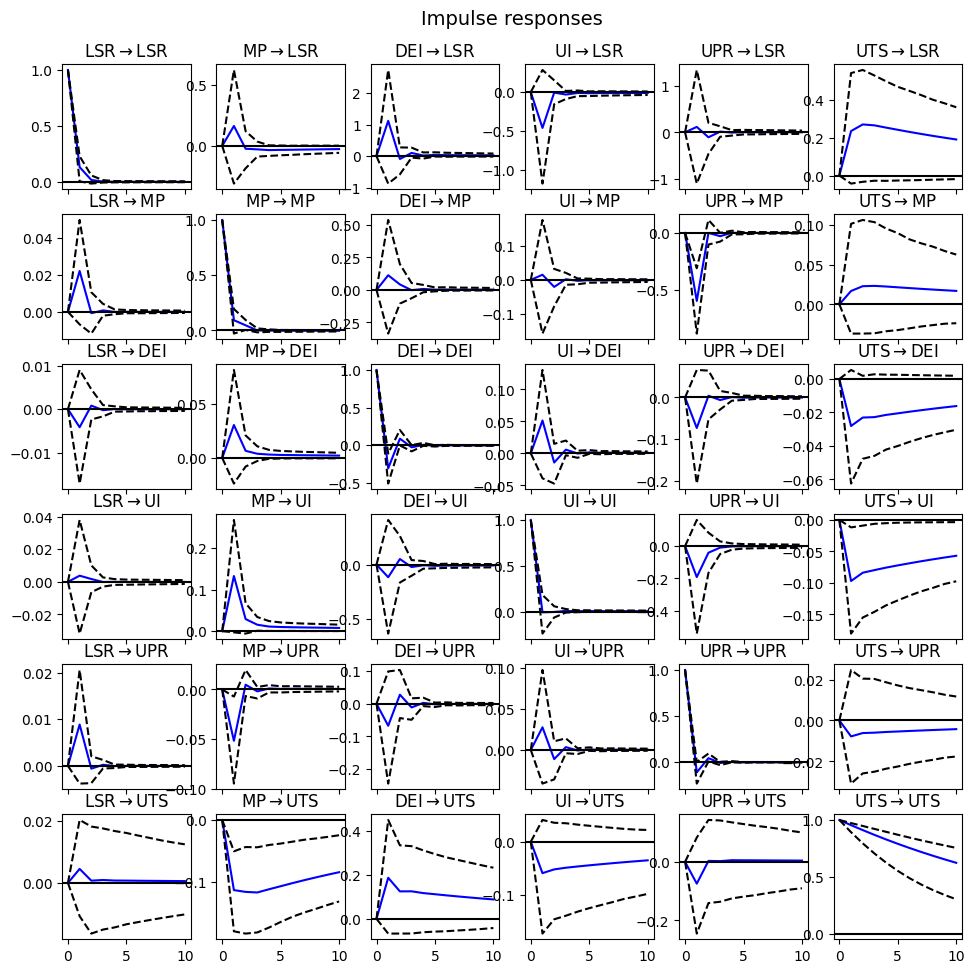

In [12]:
#Impulse Response Function
irf = results.irf(10)
irf.plot(orth=False, stderr_type='mc', repl=1000)

"""
    def get_irf_summary(irf, impulse, response):
    imp_idx = irf.model.names.index(impulse)
    resp_idx = irf.model.names.index(response)
    
    df = pd.DataFrame({
        "Period": range(irf.irfs.shape[0]),
        "IRF": irf.irfs[:, resp_idx, imp_idx]
    })
    return df

    irf_mp = get_irf_summary(irf, 'MP', 'LSR')
    print(irf_mp)
"""
def collect_all_irfs(irf_obj, alpha=0.05):
    """
    Collect IRFs and Monte Carlo confidence intervals for all impulse-response pairs.

    Parameters:
        irf_obj : statsmodels VAR IRAnalysis object
        alpha : significance level (e.g., 0.05 for 95% CI)

    Returns:
        pd.DataFrame with IRF values and CIs
    """
    # Use alpha as a positional argument
    lower, upper = irf_obj.errband_mc(alpha, repl=1000)

    variables = irf_obj.model.names
    horizon = irf_obj.irfs.shape[0]

    rows = []
    for imp_idx, impulse in enumerate(variables):
        for resp_idx, response in enumerate(variables):
            for t in range(horizon):
                rows.append({
                    'Impulse': impulse,
                    'Response': response,
                    'Period': t,
                    'IRF': irf_obj.irfs[t, resp_idx, imp_idx],
                    'Lower 95%': lower[t, resp_idx, imp_idx],
                    'Upper 95%': upper[t, resp_idx, imp_idx]
                })

    return pd.DataFrame(rows)



irf_summary = collect_all_irfs(irf)
print(irf_summary[irf_summary["Response"] == 'LSR'])



In [726]:
#Model diagnostics

# Check for autocorrelation (Ljung-Box)
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import ccf

for col in results.resid.columns:
    print(f"{col} residuals Ljung-Box p-value:")
    print(acorr_ljungbox(results.resid[col], lags=[10], return_df=True))

# Check for normality
from statsmodels.stats.stattools import jarque_bera
jb = results.test_normality()
print('Jarque Bera Test: ', jb.summary())

#Stability Test
print('Model is stable: ' , results.is_stable(verbose=True))




LSR residuals Ljung-Box p-value:
      lb_stat  lb_pvalue
10  13.144077   0.215728
MP residuals Ljung-Box p-value:
      lb_stat  lb_pvalue
10  10.057689   0.435447
DEI residuals Ljung-Box p-value:
      lb_stat  lb_pvalue
10  19.016928   0.040048
UI residuals Ljung-Box p-value:
      lb_stat  lb_pvalue
10  19.833102   0.030871
UPR residuals Ljung-Box p-value:
     lb_stat  lb_pvalue
10  31.07832    0.00057
UTS residuals Ljung-Box p-value:
      lb_stat  lb_pvalue
10  14.237976   0.162411
Jarque Bera Test:  normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         2152.          21.03   0.000 12
----------------------------------------
Eigenvalues of VAR(1) rep
0.9481723254169484
0.4662724308762792
0.4662724308762792
0.44979092634916185
0.44979092634916185
0.29253542438192437
0.29253542438192437
0.2700769264961632
0.2

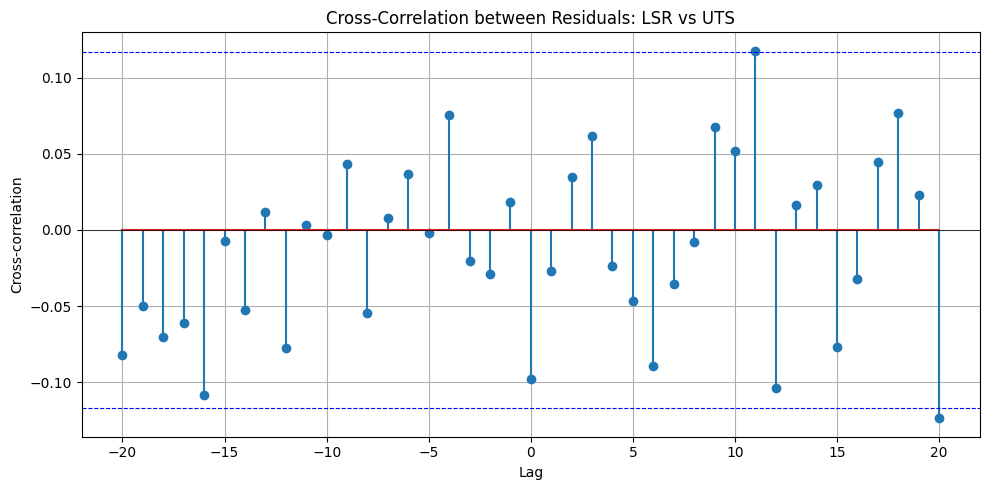

In [13]:
#Cross correlation of VAR residuals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import ccf

# Get residuals
residuals = results.resid

# Choose two variables to analyze cross-correlation
var1 = 'LSR'
var2 = 'UTS'

# Ensure no NaNs
x = residuals[var1].dropna().values
y = residuals[var2].dropna().values

# Compute CCF: correlation of x with lagged versions of y
def compute_ccf(x, y, nlags=20):
    x = (x - np.mean(x)) / np.std(x)
    y = (y - np.mean(y)) / np.std(y)
    ccf_vals = [np.corrcoef(x[max_lag:], y[max_lag - lag:len(y) - lag])[0, 1]
                if lag > 0 else
                np.corrcoef(x[:len(x)+lag], y[-lag:])[0, 1]
                for lag in range(-nlags, nlags+1)]
    return np.array(ccf_vals)

# Compute and plot
max_lag = 20
ccf_values = compute_ccf(x, y, max_lag)
lags = np.arange(-max_lag, max_lag + 1)

plt.figure(figsize=(10, 5))
plt.stem(lags, ccf_values)
plt.axhline(0, color='black', linewidth=0.5)
plt.axhline(2/np.sqrt(len(x)), color='blue', linestyle='--', linewidth=0.8)  # ~95% CI
plt.axhline(-2/np.sqrt(len(x)), color='blue', linestyle='--', linewidth=0.8)
plt.title(f'Cross-Correlation between Residuals: {var1} vs {var2}')
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.grid(True)
plt.tight_layout()
plt.show()



Jarque-Bera Test for LSR residuals:
Statistic: 181.3318, P-value: 0.0000
Skewness: -0.5299, Kurtosis: 6.7122

Jarque-Bera Test for MP residuals:
Statistic: 1272.9803, P-value: 0.0000
Skewness: -1.2932, Kurtosis: 12.8964

Jarque-Bera Test for DEI residuals:
Statistic: 1.2437, P-value: 0.5370
Skewness: 0.1599, Kurtosis: 2.9968

Jarque-Bera Test for UI residuals:
Statistic: 0.5370, P-value: 0.7645
Skewness: 0.0959, Kurtosis: 2.9144

Jarque-Bera Test for UPR residuals:
Statistic: 121.1994, P-value: 0.0000
Skewness: 0.2024, Kurtosis: 6.1301

Jarque-Bera Test for UTS residuals:
Statistic: 17.4394, P-value: 0.0002
Skewness: 0.1407, Kurtosis: 4.1637


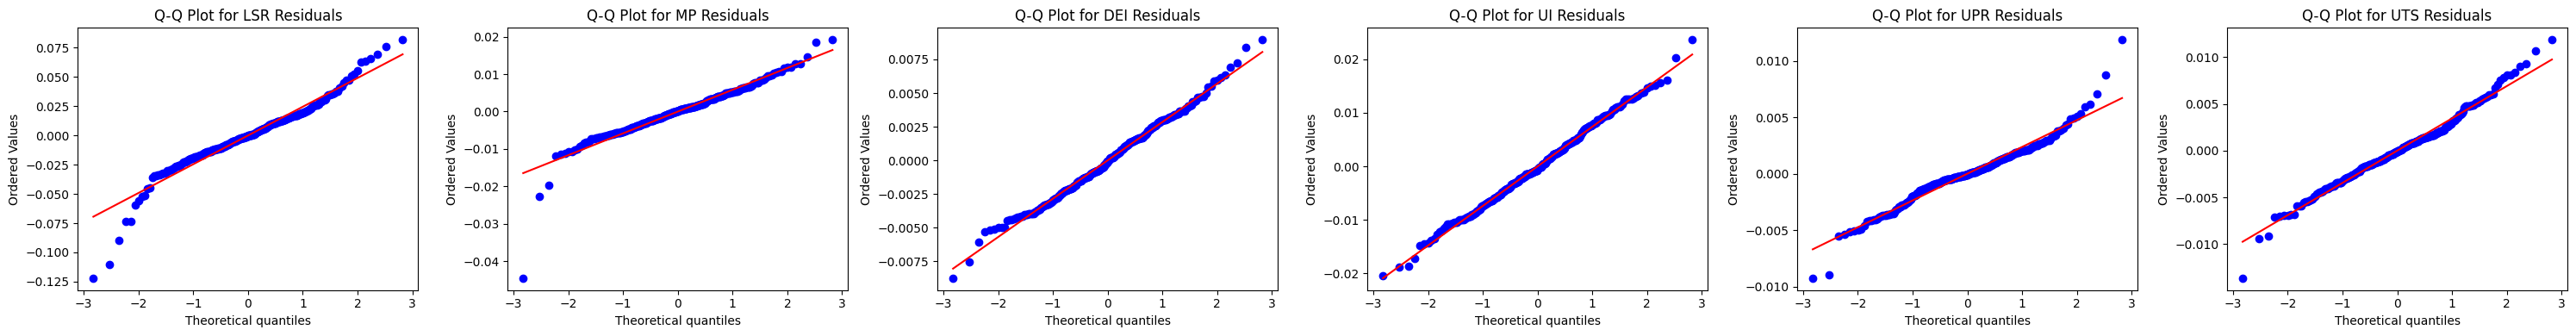

In [14]:
#Nomarlity Check for VAR Residuals
import statsmodels.stats.api as sms

# After fitting your VAR model (results object from above)
# Access residuals: results.resid (This is a pandas DataFrame)

# Jarque-Bera test for each residual series
for col in results.resid.columns:
    jb_test = sms.jarque_bera(results.resid[col])
    print(f"\nJarque-Bera Test for {col} residuals:")
    print(f"Statistic: {jb_test[0]:.4f}, P-value: {jb_test[1]:.4f}")
    print(f"Skewness: {jb_test[2]:.4f}, Kurtosis: {jb_test[3]:.4f}")

# You can also plot Q-Q plots for visual inspection:
import matplotlib.pyplot as plt
import scipy.stats as stats

fig, axes = plt.subplots(1, results.resid.shape[1], figsize=(5 * results.resid.shape[1], 4))
if results.resid.shape[1] == 1:
    axes = [axes] # Ensure axes is iterable even for a single series
for i, col in enumerate(results.resid.columns):
    stats.probplot(results.resid[col], dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q Plot for {col} Residuals')
plt.tight_layout()
plt.show()

Residuals of LSR are uncorrelated (ACF shows this)

Normality: QQ-Plots show that the distributions of the residuals do not deviate too much from the normal distribution. The test-statistic of the Jarque-Bera-Test on the otherhand shows that the residuals are significantly not normal. In the context of financial data this is expected. The result of the Jarque-Bera-Test is predominantly influenced by the leptokurtic behavior of the data.

Residuals are not normal. If I can get robust inference using the VAR model -> great


Otherwise, bootstrapping might be the solution -> complex

VAR Model Info:
- Variables: ['LSR', 'MP', 'DEI', 'UI', 'URP', 'UTS']
- Observations: 292
- Lag order: 1
- Equations: 6

Running 1000 bootstrap iterations...
Progress: 100/1000 (99 successful)
Progress: 200/1000 (199 successful)
Progress: 300/1000 (299 successful)
Progress: 400/1000 (399 successful)
Progress: 500/1000 (499 successful)
Progress: 600/1000 (599 successful)
Progress: 700/1000 (699 successful)
Progress: 800/1000 (799 successful)
Progress: 900/1000 (899 successful)
Progress: 1000/1000 (999 successful)

Completed: 1000/1000 successful iterations
VAR Model Info:
- Variables: ['Migration', 'MP', 'DEI', 'UI', 'URP', 'UTS']
- Observations: 292
- Lag order: 1
- Equations: 6

Running 1000 bootstrap iterations...
Progress: 100/1000 (99 successful)
Progress: 200/1000 (199 successful)
Progress: 300/1000 (299 successful)
Progress: 400/1000 (399 successful)
Progress: 500/1000 (499 successful)
Progress: 600/1000 (599 successful)
Progress: 700/1000 (699 successful)
Progress: 800/1000 (799

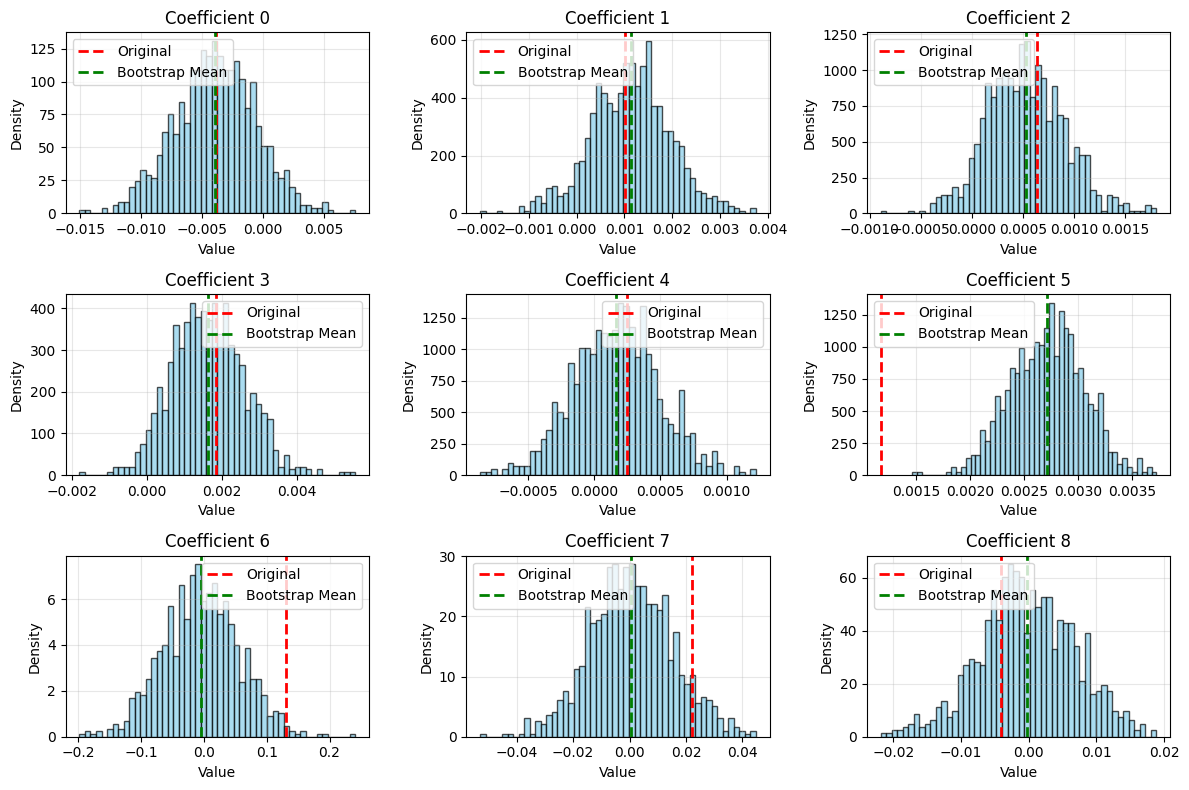

VAR Model Bootstrap Summary
Model: VAR(1)
Variables: LSR, MP, DEI, UI, URP, UTS
Observations: 292
Bootstrap iterations: 1000
Bootstrap success rate: 100.0%

Bootstrap Coefficient Results
Total parameters: 42
Parameters per equation: 7
----------------------------------------------------------------------------------------------------
Parameter            Equation   Coefficient  Bootstrap SE t-stat   P>|t|    [95.0% CI]         Sig 
----------------------------------------------------------------------------------------------------
const                LSR        -0.003906    0.003306     -1.182   0.218    [ -0.010,   0.002]     
L1.LSR               LSR        0.001129     0.000832     1.356    0.158    [ -0.001,   0.003]     
L1.MP                LSR        0.000530     0.000381     1.393    0.134    [ -0.000,   0.001]     
L1.DEI               LSR        0.001628     0.000974     1.671    0.072    [ -0.000,   0.003] .   
L1.UI                LSR        0.000168     0.000325     0.517

In [24]:
import numpy as np
import pandas as pd
from statsmodels.tsa.vector_ar.var_model import VAR
from scipy import stats
import matplotlib.pyplot as plt

def bootstrap_var_residuals_targeted(results, n_bootstrap=1000, random_state=None):
    """
    Bootstrap specifically designed for your VAR model setup
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Extract key components
    residuals = results.resid.values if hasattr(results.resid, 'values') else results.resid
    fitted_values = results.fittedvalues.values if hasattr(results.fittedvalues, 'values') else results.fittedvalues
    original_data = results.endog.values if hasattr(results.endog, 'values') else results.endog
    n_obs, n_vars = residuals.shape
    lag_order = results.k_ar
    
    print(f"VAR Model Info:")
    print(f"- Variables: {results.names}")
    print(f"- Observations: {n_obs}")
    print(f"- Lag order: {lag_order}")
    print(f"- Equations: {n_vars}")
    
    bootstrap_coefs = []
    bootstrap_fits = []
    successful_iterations = 0
    
    print(f"\nRunning {n_bootstrap} bootstrap iterations...")
    
    for i in range(n_bootstrap):
        if (i + 1) % 100 == 0:
            print(f"Progress: {i + 1}/{n_bootstrap} ({successful_iterations} successful)")
        
        try:
            # Resample residuals (preserving cross-equation correlation structure)
            bootstrap_indices = np.random.choice(n_obs, size=n_obs, replace=True)
            bootstrap_residuals = residuals[bootstrap_indices]
            
            # Reconstruct bootstrap data
            bootstrap_data = fitted_values + bootstrap_residuals
            
            # Convert back to DataFrame with proper column names
            bootstrap_df = pd.DataFrame(bootstrap_data, columns=results.names)
            
            # Fit new VAR model with same specification as original
            bootstrap_model = VAR(bootstrap_df)
            bootstrap_fit = bootstrap_model.fit(
                maxlags=lag_order, 
                ic=None,  # Use fixed lag order
                trend='c'  # Assuming constant trend (adjust if needed)
            )
            bootstrap_fits.append(bootstrap_fit)    
            
            # Extract and store coefficients
            coef_vector = bootstrap_fit.params.values.flatten()
            bootstrap_coefs.append(coef_vector)
            successful_iterations += 1

            #Store residuals for later analysis
            last_bootstrap_residuals = bootstrap_fit.resid
            bootstrap_model = bootstrap_fit
            
        except Exception as e:
            # Only print first few errors for debugging
            if i < 5:
                print(f"  Error in iteration {i}: {str(e)[:100]}...")
            continue
    
    print(f"\nCompleted: {successful_iterations}/{n_bootstrap} successful iterations")
    
    if successful_iterations == 0:
        raise ValueError("No bootstrap iterations succeeded. Check model specification.")
    
    if successful_iterations < n_bootstrap * 0.5:
        print(f"Warning: Only {successful_iterations/n_bootstrap:.1%} of bootstrap iterations succeeded.")
    
    # Convert to numpy array
    bootstrap_coefs = np.array(bootstrap_coefs)
    
    # Calculate bootstrap statistics
    coef_means = np.mean(bootstrap_coefs, axis=0)
    coef_stds = np.std(bootstrap_coefs, axis=0)
    coef_ci_lower = np.percentile(bootstrap_coefs, 2.5, axis=0)
    coef_ci_upper = np.percentile(bootstrap_coefs, 97.5, axis=0)
    
    return {
        'bootstrap_coefficients': bootstrap_coefs,
        'coefficient_means': coef_means,
        'coefficient_stds': coef_stds,
        'coefficient_ci_lower': coef_ci_lower,
        'coefficient_ci_upper': coef_ci_upper,
        'original_results': results,
        'n_successful_iterations': successful_iterations,
        'success_rate': successful_iterations / n_bootstrap,
        'last_bootstrap_residuals': last_bootstrap_residuals,
        'bootstrap_model': bootstrap_model,
        'bootstrap_fits': bootstrap_fits
    }
    """
    Bootstrap specifically designed for your VAR model setup
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Extract key components
    residuals = results.resid.values  # Shape: (n_obs, n_equations)
    fitted_values = results.fittedvalues.values
    original_data = results.endog.values
    n_obs, n_vars = residuals.shape
    lag_order = results.k_ar
    
    print(f"VAR Model Info:")
    print(f"- Variables: {results.names}")
    print(f"- Observations: {n_obs}")
    print(f"- Lag order: {lag_order}")
    print(f"- Equations: {n_vars}")
    
    bootstrap_coefs = []
    successful_iterations = 0
    
    print(f"\nRunning {n_bootstrap} bootstrap iterations...")
    
    for i in range(n_bootstrap):
        if (i + 1) % 100 == 0:
            print(f"Progress: {i + 1}/{n_bootstrap} ({successful_iterations} successful)")
        
        try:
            # Resample residuals (preserving cross-equation correlation structure)
            bootstrap_indices = np.random.choice(n_obs, size=n_obs, replace=True)
            bootstrap_residuals = residuals[bootstrap_indices]
            
            # Reconstruct bootstrap data
            bootstrap_data = fitted_values + bootstrap_residuals
            
            # Convert back to DataFrame with proper column names
            bootstrap_df = pd.DataFrame(bootstrap_data, columns=results.names)
            
            # Fit new VAR model with same specification as original
            bootstrap_model = VAR(bootstrap_df)
            bootstrap_fit = bootstrap_model.fit(
                maxlags=lag_order, 
                ic=None,  # Use fixed lag order
                trend='c'  # Assuming constant trend (adjust if needed)
            )
            
            # Extract and store coefficients
            coef_vector = bootstrap_fit.params.values.flatten()
            bootstrap_coefs.append(coef_vector)
            successful_iterations += 1
            
        except Exception as e:
            # Only print first few errors for debugging
            if i < 5:
                print(f"  Error in iteration {i}: {str(e)[:100]}...")
            continue
    
    print(f"\nCompleted: {successful_iterations}/{n_bootstrap} successful iterations")
    
    if successful_iterations == 0:
        raise ValueError("No bootstrap iterations succeeded. Check model specification.")
    
    if successful_iterations < n_bootstrap * 0.5:
        print(f"Warning: Only {successful_iterations/n_bootstrap:.1%} of bootstrap iterations succeeded.")
    
    # Convert to numpy array
    bootstrap_coefs = np.array(bootstrap_coefs)
    
    # Calculate bootstrap statistics
    coef_means = np.mean(bootstrap_coefs, axis=0)
    coef_stds = np.std(bootstrap_coefs, axis=0)
    coef_ci_lower = np.percentile(bootstrap_coefs, 2.5, axis=0)
    coef_ci_upper = np.percentile(bootstrap_coefs, 97.5, axis=0)


    irf = bootstrap_fit.irf(10)
    irf.plot(orth=False, stderr_type='mc', repl=1000)

    return {
        'bootstrap_coefficients': bootstrap_coefs,
        'coefficient_means': coef_means,
        'coefficient_stds': coef_stds,
        'coefficient_ci_lower': coef_ci_lower,
        'coefficient_ci_upper': coef_ci_upper,
        'original_results': results,
        'n_successful_iterations': successful_iterations,
        'success_rate': successful_iterations / n_bootstrap,
        'bootstrap_residuals': bootstrap_coefs[''],
        'bootstrap_fits': bootstrap_fits
    }

def get_bootstrap_inference(bootstrap_results, coefficient_index=None, alpha=0.05):
    """
    Extract inference statistics from bootstrap results
    
    Parameters:
    -----------
    bootstrap_results : dict
        Results from bootstrap_var_residuals
    coefficient_index : int or None
        Specific coefficient index to analyze (None for all)
    alpha : float
        Significance level for confidence intervals
    
    Returns:
    --------
    DataFrame with inference statistics
    """
    coefs = bootstrap_results['bootstrap_coefficients']
    
    if coefficient_index is not None:
        coefs = coefs[:, coefficient_index:coefficient_index+1]
    
    # Calculate statistics
    means = np.mean(coefs, axis=0)
    stds = np.std(coefs, axis=0)
    
    # Confidence intervals
    ci_lower = np.percentile(coefs, (alpha/2) * 100, axis=0)
    ci_upper = np.percentile(coefs, (1 - alpha/2) * 100, axis=0)
    
    # T-statistics (using bootstrap standard errors)
    t_stats = means / stds
    
    # P-values (two-tailed test, using bootstrap distribution)
    p_values = []
    for i in range(coefs.shape[1]):
        # Count how many bootstrap samples have opposite sign from mean
        opposite_sign_count = np.sum(np.sign(coefs[:, i]) != np.sign(means[i]))
        p_val = 2 * min(opposite_sign_count, len(coefs) - opposite_sign_count) / len(coefs)
        p_values.append(p_val)
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'coefficient': means,
        'bootstrap_se': stds,
        't_statistic': t_stats,
        'p_value': p_values,
        f'ci_lower_{int((1-alpha)*100)}%': ci_lower,
        f'ci_upper_{int((1-alpha)*100)}%': ci_upper
    })
    
    return results_df

def plot_bootstrap_distribution(bootstrap_results, coefficient_indices=None, figsize=(12, 8)):
    """
    Plot bootstrap distribution of coefficients
    """
    coefs = bootstrap_results['bootstrap_coefficients']
    original_coefs = bootstrap_results['original_results'].params.values.flatten()
    
    if coefficient_indices is None:
        coefficient_indices = range(min(9, coefs.shape[1]))  # Plot first 9 coefficients
    
    n_plots = len(coefficient_indices)
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_plots == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes
    else:
        axes = axes.flatten()
    
    for i, coef_idx in enumerate(coefficient_indices):
        ax = axes[i] if n_plots > 1 else axes[0]
        
        # Plot histogram of bootstrap coefficients
        ax.hist(coefs[:, coef_idx], bins=50, alpha=0.7, density=True, 
                color='skyblue', edgecolor='black')
        
        # Add vertical line for original coefficient
        ax.axvline(original_coefs[coef_idx], color='red', linestyle='--', 
                  linewidth=2, label='Original')
        
        # Add vertical line for bootstrap mean
        bootstrap_mean = np.mean(coefs[:, coef_idx])
        ax.axvline(bootstrap_mean, color='green', linestyle='--', 
                  linewidth=2, label='Bootstrap Mean')
        
        ax.set_title(f'Coefficient {coef_idx}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Hide empty subplots
    for i in range(n_plots, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def create_bootstrap_summary(bootstrap_results, equation_name=None):
    """
    Create a summary table comparing original and bootstrap results
    """
    original = bootstrap_results['original_results']
    
    # Get original coefficient names and values
    original_params = original.params
    bootstrap_means = bootstrap_results['coefficient_means']
    bootstrap_stds = bootstrap_results['coefficient_stds']
    bootstrap_ci_lower = bootstrap_results['coefficient_ci_lower']
    bootstrap_ci_upper = bootstrap_results['coefficient_ci_upper']
    
    # Create comparison DataFrame
    if equation_name and equation_name in original_params.index:
        # Focus on specific equation
        eq_params = original_params.loc[equation_name]
        eq_stderr = original.stderr.loc[equation_name]
        
        # Find corresponding bootstrap indices (this is approximate)
        n_params_per_eq = len(eq_params)
        eq_index = list(original_params.index).index(equation_name)
        start_idx = eq_index * n_params_per_eq
        end_idx = start_idx + n_params_per_eq
        
        comparison_df = pd.DataFrame({
            'Variable': eq_params.index,
            'Original_Coef': eq_params.values,
            'Original_SE': eq_stderr.values,
            'Bootstrap_Coef': bootstrap_means[start_idx:end_idx],
            'Bootstrap_SE': bootstrap_stds[start_idx:end_idx],
            'Bootstrap_CI_Lower': bootstrap_ci_lower[start_idx:end_idx],
            'Bootstrap_CI_Upper': bootstrap_ci_upper[start_idx:end_idx]
        })
    else:
        # Full model summary
        all_param_names = []
        all_original_coefs = []
        all_original_se = []
        
        for eq_name in original.names:
            eq_params = original_params.loc[eq_name]
            eq_stderr = original.stderr.loc[eq_name]
            
            for param_name in eq_params.index:
                all_param_names.append(f"{eq_name}_{param_name}")
                all_original_coefs.append(eq_params[param_name])
                all_original_se.append(eq_stderr[param_name])
        
        comparison_df = pd.DataFrame({
            'Parameter': all_param_names,
            'Original_Coef': all_original_coefs,
            'Original_SE': all_original_se,
            'Bootstrap_Coef': bootstrap_means,
            'Bootstrap_SE': bootstrap_stds,
            'Bootstrap_CI_Lower': bootstrap_ci_lower,
            'Bootstrap_CI_Upper': bootstrap_ci_upper
        })
    
    # Add significance indicators
    comparison_df['Bootstrap_Significant'] = (
        (comparison_df['Bootstrap_CI_Lower'] > 0) | 
        (comparison_df['Bootstrap_CI_Upper'] < 0)
    )
    
    return comparison_df

# Example usage with your model:
    """
    Block bootstrap for VAR residuals (preserves temporal dependencies)
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    residuals = results.resid.values
    n_obs, n_vars = residuals.shape
    
    # Default block length
    if block_length is None:
        block_length = max(1, int(np.sqrt(n_obs)))
    
    bootstrap_coefs = []
    
    print(f"Running block bootstrap with block length {block_length}...")
    
    for i in range(n_bootstrap):
        try:
            # Generate block bootstrap sample
            bootstrap_residuals = []
            current_length = 0
            
            while current_length < n_obs:
                # Random starting point for block
                start_idx = np.random.randint(0, n_obs - block_length + 1)
                block = residuals[start_idx:start_idx + block_length]
                
                # Add block (may truncate if it exceeds needed length)
                remaining = n_obs - current_length
                if len(block) > remaining:
                    block = block[:remaining]
                
                bootstrap_residuals.append(block)
                current_length += len(block)
            
            bootstrap_residuals = np.vstack(bootstrap_residuals)[:n_obs]
            
            # Reconstruct data
            fitted_values = results.fittedvalues.values
            bootstrap_data = fitted_values + bootstrap_residuals
            
            # Fit VAR
            bootstrap_model = VAR(bootstrap_data)
            bootstrap_fit = bootstrap_model.fit(maxlags=results.k_ar, ic=None, trend='c' if results.k_trend > 0 else 'n')
            
            bootstrap_coefs.append(bootstrap_fit.params.values.flatten())

            
        except Exception as e:
            if i < 3:
                print(f"Block bootstrap error in iteration {i}: {e}")
            continue
    
    if len(bootstrap_coefs) == 0:
        raise ValueError("Block bootstrap also failed. Check your VAR model specification.")
    
    bootstrap_coefs = np.array(bootstrap_coefs)
    print(f"Block bootstrap: {len(bootstrap_coefs)} successful iterations")
    
    return {
        'bootstrap_coefficients': bootstrap_coefs,
        'coefficient_means': np.mean(bootstrap_coefs, axis=0),
        'coefficient_stds': np.std(bootstrap_coefs, axis=0),
        'coefficient_ci_lower': np.percentile(bootstrap_coefs, 2.5, axis=0),
        'coefficient_ci_upper': np.percentile(bootstrap_coefs, 97.5, axis=0),
        'original_results': results,
        'n_successful_iterations': len(bootstrap_coefs)
    }


bootstrap_results = bootstrap_var_residuals_targeted(results, n_bootstrap=1000, random_state=42)
bootstrap_results_mig = bootstrap_var_residuals_targeted(results_mig, n_bootstrap=1000, random_state=42)
bootstrap_results_iy = bootstrap_var_residuals_targeted(results_iy, n_bootstrap=1000, random_state=42)
bootstrap_results_cav = bootstrap_var_residuals_targeted(results_cav, n_bootstrap=1000, random_state=42)

# Get inference statistics
inference_stats = get_bootstrap_inference(bootstrap_results)
print("Bootstrap Inference Results:")
print(inference_stats)

# Plot bootstrap distributions
plot_bootstrap_distribution(bootstrap_results)

def create_bootstrap_model_summary(bootstrap_results, alpha=0.05):

    """
    Create a comprehensive model summary using bootstrap results
    """
    original = bootstrap_results['original_results']
    bootstrap_coefs = bootstrap_results['bootstrap_coefficients']
    
    print("="*80)
    print("VAR Model Summary with Bootstrap Inference")
    print("="*80)
    print(f"Model: VAR({original.k_ar})")
    print(f"Variables: {', '.join(original.names)}")
    print(f"Observations: {original.nobs}")
    print(f"Bootstrap iterations: {bootstrap_results['n_successful_iterations']}")
    print(f"Bootstrap success rate: {bootstrap_results['success_rate']:.1%}")
    print("-"*80)
    
    # Get parameter structure
    param_names = []
    original_coefs = []
    original_se = []
    original_tvals = []
    original_pvals = []
    
    for eq_name in original.names:
        eq_params = original.params.loc[eq_name]
        eq_stderr = original.stderr.loc[eq_name]
        eq_tvalues = original.tvalues.loc[eq_name]
        eq_pvalues = original.pvalues.loc[eq_name]
        
        for param_name in eq_params.index:
            param_names.append(f"{eq_name}.{param_name}")
            original_coefs.append(eq_params[param_name])
            original_se.append(eq_stderr[param_name])
            original_tvals.append(eq_tvalues[param_name])
            original_pvals.append(eq_pvalues[param_name])
    
    # Bootstrap statistics
    bootstrap_means = bootstrap_results['coefficient_means']
    bootstrap_se = bootstrap_results['coefficient_stds']
    bootstrap_ci_lower = bootstrap_results['coefficient_ci_lower']
    bootstrap_ci_upper = bootstrap_results['coefficient_ci_upper']
    
    # Bootstrap t-statistics and p-values
    bootstrap_t = bootstrap_means / bootstrap_se
    
    # Bootstrap p-values (two-tailed test using bootstrap distribution)
    bootstrap_pvals = []
    for i in range(len(bootstrap_means)):
        # Count proportion of bootstrap samples with opposite sign
        coef_samples = bootstrap_coefs[:, i]
        if bootstrap_means[i] == 0:
            p_val = 1.0
        else:
            # Two-tailed test: proportion of samples with opposite sign * 2
            opposite_sign_prop = np.mean(np.sign(coef_samples) != np.sign(bootstrap_means[i]))
            p_val = 2 * min(opposite_sign_prop, 1 - opposite_sign_prop)
        bootstrap_pvals.append(p_val)
    
    # Create summary by equation
    param_idx = 0
    for eq_name in original.names:
        print(f"\nResults for equation {eq_name}")
        print("="*60)
        print(f"{'Variable':<12} {'Coef':<10} {'Bootstrap SE':<12} {'t-stat':<8} {'P>|t|':<8} {'[{:.1f}% Conf. Int.]':<20}".format((1-alpha)*100))
        print("-"*80)
        
        eq_params = original.params.loc[eq_name]
        for param_name in eq_params.index:
            coef = bootstrap_means[param_idx]
            se = bootstrap_se[param_idx]
            t_stat = bootstrap_t[param_idx]
            p_val = bootstrap_pvals[param_idx]
            ci_lower = bootstrap_ci_lower[param_idx]
            ci_upper = bootstrap_ci_upper[param_idx]
            
            # Significance stars
            stars = ""
            if p_val < 0.001:
                stars = "***"
            elif p_val < 0.01:
                stars = "**"
            elif p_val < 0.05:
                stars = "*"
            elif p_val < 0.1:
                stars = "."
            
            print(f"{param_name:<12} {coef:<10.6f} {se:<12.6f} {t_stat:<8.3f} {p_val:<8.3f} [{ci_lower:>8.3f}, {ci_upper:>8.3f}] {stars}")
            param_idx += 1
    
    print("\n" + "="*80)
    print("Significance codes: 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1")
    print("Standard errors and confidence intervals based on bootstrap distribution")
    print("="*80)
    
    return {
        'parameter_names': param_names,
        'bootstrap_coefficients': bootstrap_means,
        'bootstrap_se': bootstrap_se,
        'bootstrap_t_stats': bootstrap_t,
        'bootstrap_p_values': bootstrap_pvals,
        'confidence_intervals': list(zip(bootstrap_ci_lower, bootstrap_ci_upper))
    }

def compare_original_vs_bootstrap(bootstrap_results, equation_name=None):
    """
    Side-by-side comparison of original vs bootstrap results
    """
    original = bootstrap_results['original_results']
    
    if equation_name:
        equations = [equation_name]
    else:
        equations = original.names
    
    print("="*100)
    print("Comparison: Original vs Bootstrap Results")
    print("="*100)
    
    for eq_name in equations:
        print(f"\nEquation: {eq_name}")
        print("-"*90)
        print(f"{'Variable':<12} {'Original':<25} {'Bootstrap':<25} {'Difference':<15}")
        print(f"{'':>12} {'Coef':<8} {'SE':<8} {'P-val':<8} {'Coef':<8} {'SE':<8} {'P-val':<8} {'Coef':<8}")
        print("-"*90)
        
        eq_params = original.params.loc[eq_name]
        eq_stderr = original.stderr.loc[eq_name]
        eq_pvalues = original.pvalues.loc[eq_name]
        
        # Find bootstrap indices for this equation
        param_idx = 0
        for i, other_eq in enumerate(original.names):
            if other_eq == eq_name:
                break
            param_idx += len(original.params.loc[other_eq])
        
        for j, param_name in enumerate(eq_params.index):
            orig_coef = eq_params[param_name]
            orig_se = eq_stderr[param_name]
            orig_pval = eq_pvalues[param_name]
            
            boot_coef = bootstrap_results['coefficient_means'][param_idx + j]
            boot_se = bootstrap_results['coefficient_stds'][param_idx + j]
            # Calculate bootstrap p-value
            coef_samples = bootstrap_results['bootstrap_coefficients'][:, param_idx + j]
            if boot_coef == 0:
                boot_pval = 1.0
            else:
                opposite_sign_prop = np.mean(np.sign(coef_samples) != np.sign(boot_coef))
                boot_pval = 2 * min(opposite_sign_prop, 1 - opposite_sign_prop)
            
            coef_diff = boot_coef - orig_coef
            
            print(f"{param_name:<12} {orig_coef:<8.4f} {orig_se:<8.4f} {orig_pval:<8.3f} {boot_coef:<8.4f} {boot_se:<8.4f} {boot_pval:<8.3f} {coef_diff:<8.4f}")

# Example usage with your model:
    """
    Block bootstrap for VAR residuals (preserves temporal dependencies)
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    residuals = results.resid.values
    n_obs, n_vars = residuals.shape
    
    # Default block length
    if block_length is None:
        block_length = max(1, int(np.sqrt(n_obs)))
    
    bootstrap_coefs = []
    
    print(f"Running block bootstrap with block length {block_length}...")
    
    for i in range(n_bootstrap):
        try:
            # Generate block bootstrap sample
            bootstrap_residuals = []
            current_length = 0
            
            while current_length < n_obs:
                # Random starting point for block
                start_idx = np.random.randint(0, n_obs - block_length + 1)
                block = residuals[start_idx:start_idx + block_length]
                
                # Add block (may truncate if it exceeds needed length)
                remaining = n_obs - current_length
                if len(block) > remaining:
                    block = block[:remaining]
                
                bootstrap_residuals.append(block)
                current_length += len(block)
            
            bootstrap_residuals = np.vstack(bootstrap_residuals)[:n_obs]
            
            # Reconstruct data
            fitted_values = results.fittedvalues.values
            bootstrap_data = fitted_values + bootstrap_residuals
            
            # Fit VAR
            bootstrap_model = VAR(bootstrap_data)
            bootstrap_fit = bootstrap_model.fit(maxlags=results.k_ar, ic=None, trend='c' if results.k_trend > 0 else 'n')
            
            bootstrap_coefs.append(bootstrap_fit.params.values.flatten())
            
        except Exception as e:
            if i < 3:
                print(f"Block bootstrap error in iteration {i}: {e}")
            continue
    
    if len(bootstrap_coefs) == 0:
        raise ValueError("Block bootstrap also failed. Check your VAR model specification.")
    
    bootstrap_coefs = np.array(bootstrap_coefs)
    print(f"Block bootstrap: {len(bootstrap_coefs)} successful iterations")
    
    return {
        'bootstrap_coefficients': bootstrap_coefs,
        'coefficient_means': np.mean(bootstrap_coefs, axis=0),
        'coefficient_stds': np.std(bootstrap_coefs, axis=0),
        'coefficient_ci_lower': np.percentile(bootstrap_coefs, 2.5, axis=0),
        'coefficient_ci_upper': np.percentile(bootstrap_coefs, 97.5, axis=0),
        'original_results': results,
        'n_successful_iterations': len(bootstrap_coefs)
    }

def simple_bootstrap_summary(bootstrap_results, alpha=0.05):
    """
    Simplified bootstrap summary that doesn't rely on complex parameter indexing
    """
    original = bootstrap_results['original_results']
    print("="*80)
    print("VAR Model Bootstrap Summary")
    print("="*80)
    print(f"Model: VAR({original.k_ar})")
    print(f"Variables: {', '.join(original.names)}")
    print(f"Observations: {original.nobs}")
    print(f"Bootstrap iterations: {bootstrap_results['n_successful_iterations']}")
    print(f"Bootstrap success rate: {bootstrap_results['success_rate']:.1%}")
    print("="*80)
    
    # Bootstrap statistics
    bootstrap_means = bootstrap_results['coefficient_means']
    bootstrap_se = bootstrap_results['coefficient_stds']
    bootstrap_ci_lower = bootstrap_results['coefficient_ci_lower']
    bootstrap_ci_upper = bootstrap_results['coefficient_ci_upper']
    bootstrap_t = bootstrap_means / bootstrap_se
    
    # Bootstrap p-values
    bootstrap_coefs = bootstrap_results['bootstrap_coefficients']
    bootstrap_pvals = []
    for i in range(len(bootstrap_means)):
        coef_samples = bootstrap_coefs[:, i]
        if bootstrap_means[i] == 0:
            p_val = 1.0
        else:
            opposite_sign_prop = np.mean(np.sign(coef_samples) != np.sign(bootstrap_means[i]))
            p_val = 2 * min(opposite_sign_prop, 1 - opposite_sign_prop)
        bootstrap_pvals.append(p_val)
    
    # Extract parameter names from the original VAR model
    param_names = []
    n_equations = len(original.names)
    
    # Get parameter names from the VAR model
    # VARResults stores parameters differently - use the coefficient matrix structure
    try:
        # Try to get parameter names from the model's parameter structure
        if hasattr(original, 'params'):
            # Flatten the parameter matrix and get names
            param_names = original.params.index.tolist()
        elif hasattr(original, 'coef'):
            # Alternative: construct parameter names based on VAR structure
            param_names = []
            for eq_name in original.names:
                # Add intercept
                param_names.append('const')
                # Add lagged variables
                for lag in range(1, original.k_ar + 1):
                    for var_name in original.names:
                        param_names.append(f'L{lag}.{var_name}')
        else:
            # Fallback: create generic parameter names
            param_names = [f'param_{i}' for i in range(n_params)]
    except:
        # If all else fails, create generic parameter names
        param_names = [f'param_{i}' for i in range(n_params)]
    
    # Calculate parameters per equation
    n_params = len(bootstrap_means)
    params_per_eq = n_params // n_equations
    
    print(f"\nBootstrap Coefficient Results")
    print(f"Total parameters: {n_params}")
    print(f"Parameters per equation: {params_per_eq}")
    print("-"*100)
    print(f"{'Parameter':<20} {'Equation':<10} {'Coefficient':<12} {'Bootstrap SE':<12} {'t-stat':<8} {'P>|t|':<8} {'[{:.1f}% CI]':<20} {'Sig':<4}".format((1-alpha)*100))
    print("-"*100)

    for i in range(n_params):
        coef = bootstrap_means[i]
        se = bootstrap_se[i]
        t_stat = bootstrap_t[i]
        p_val = bootstrap_pvals[i]
        ci_lower = bootstrap_ci_lower[i]
        ci_upper = bootstrap_ci_upper[i]
        
        # Significance stars
        stars = ""
        if p_val < 0.001:
            stars = "***"
        elif p_val < 0.01:
            stars = "**"
        elif p_val < 0.05:
            stars = "*"
        elif p_val < 0.1:
            stars = "."
        
        # Determine which equation this parameter belongs to
        eq_idx = i // params_per_eq
        param_in_eq = i % params_per_eq
        eq_name = original.names[eq_idx] if eq_idx < len(original.names) else f"Eq{eq_idx}"
        
        # Get parameter name
        if i < len(param_names):
            param_name = param_names[i]
        else:
            param_name = f"param_{i}"
        
        print(f"{param_name:<20} {eq_name:<10} {coef:<12.6f} {se:<12.6f} {t_stat:<8.3f} {p_val:<8.3f} [{ci_lower:>7.3f}, {ci_upper:>7.3f}] {stars:<4}")
    
    print("\n" + "="*100)
    print("Significance codes: 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1")
    print("Standard errors and confidence intervals based on bootstrap distribution")
    print("="*100)
    
    # Summary statistics
    significant_params = np.sum(np.array(bootstrap_pvals) < 0.05)
    print(f"\nSummary:")
    print(f"- Total parameters: {n_params}")
    print(f"- Significant at 5% level: {significant_params} ({significant_params/n_params:.1%})")
    print(f"- Bootstrap success rate: {bootstrap_results['success_rate']:.1%}")    
    
    return {
        'bootstrap_coefficients': bootstrap_means,
        'bootstrap_se': bootstrap_se,
        'bootstrap_t_stats': bootstrap_t,
        'bootstrap_p_values': bootstrap_pvals,
        'confidence_intervals': list(zip(bootstrap_ci_lower, bootstrap_ci_upper)),
        'n_significant': significant_params,
        'parameter_names': param_names
    }

# Generate bootstrap model summary
summary_stats = simple_bootstrap_summary(bootstrap_results)
summary_stats_mig = simple_bootstrap_summary(bootstrap_results_mig)
summary_stats_iy = simple_bootstrap_summary(bootstrap_results_iy)
summary_stats_cav = simple_bootstrap_summary(bootstrap_results_cav)

# Compare original vs bootstrap results
#compare_original_vs_bootstrap(bootstrap_results)

# Or focus on a specific equation
#compare_original_vs_bootstrap(bootstrap_results, equation_name='LSR')


In [731]:
#Latex export of bootstrapped VAR model

import numpy as np

def escape_latex(text):
    """
    Escape underscores and special characters in LaTeX
    """
    return text.replace('_', r'\_')

def save_bootstrap_summary_to_latex(bootstrap_results, output_tex_path="bootstrap_summary.tex", alpha=0.05):
    original = bootstrap_results['original_results']
    
    bootstrap_means = bootstrap_results['coefficient_means']
    bootstrap_se = bootstrap_results['coefficient_stds']
    bootstrap_ci_lower = bootstrap_results['coefficient_ci_lower']
    bootstrap_ci_upper = bootstrap_results['coefficient_ci_upper']
    bootstrap_t = bootstrap_means / bootstrap_se
    bootstrap_coefs = bootstrap_results['bootstrap_coefficients']
    
    bootstrap_pvals = []
    for i in range(len(bootstrap_means)):
        coef_samples = bootstrap_coefs[:, i]
        if bootstrap_means[i] == 0:
            p_val = 1.0
        else:
            opposite_sign_prop = np.mean(np.sign(coef_samples) != np.sign(bootstrap_means[i]))
            p_val = 2 * min(opposite_sign_prop, 1 - opposite_sign_prop)
        bootstrap_pvals.append(p_val)
    
    param_names = []
    n_equations = len(original.names)
    n_params = len(bootstrap_means)
    params_per_eq = n_params // n_equations

    if hasattr(original, 'params') and hasattr(original.params, 'index'):
        param_names = original.params.index.tolist()
    else:
        for eq_name in original.names:
            param_names.append('const')
            for lag in range(1, original.k_ar + 1):
                for var_name in original.names:
                    param_names.append(f'L{lag}.{var_name}')

    while len(param_names) < n_params:
        param_names.append(f'param_{len(param_names)}')

    # Start building LaTeX string
    latex = []
    latex.append(r"\documentclass{article}")
    latex.append(r"\usepackage{booktabs}")
    latex.append(r"\usepackage[margin=1in]{geometry}")
    latex.append(r"\usepackage{amsmath}")
    latex.append(r"\usepackage{longtable}")
    latex.append(r"\begin{document}")
    latex.append(r"\section*{VAR Model Bootstrap Summary}")
    latex.append(f"\\textbf{{Model:}} VAR({original.k_ar})\\\\")
    latex.append(f"\\textbf{{Variables:}} {', '.join([escape_latex(v) for v in original.names])}\\\\")
    latex.append(f"\\textbf{{Observations:}} {original.nobs}\\\\")
    latex.append(f"\\textbf{{Bootstrap iterations:}} {bootstrap_results['n_successful_iterations']}\\\\")
    latex.append(f"\\textbf{{Bootstrap success rate:}} {bootstrap_results['success_rate']:.1%}\\\\")
    
    latex.append(r"\bigskip")
    latex.append(r"\begin{longtable}{lllllll}")
    latex.append(r"\toprule")
    latex.append("Parameter & Equation & Coef. & SE & t-stat & $P{{>}}|t|$ & ${:.1f}\\%$ CI \\\\".format((1-alpha)*100))
    latex.append(r"\midrule")
    latex.append(r"\endfirsthead")
    latex.append(r"\toprule")
    latex.append("Parameter & Equation & Coef. & SE & t-stat & $P{{>}}|t|$ & ${:.1f}\\%$ CI \\\\".format((1-alpha)*100))
    latex.append(r"\midrule")
    latex.append(r"\endhead")

    for i in range(n_params):
        coef = bootstrap_means[i]
        se = bootstrap_se[i]
        t_stat = bootstrap_t[i]
        p_val = bootstrap_pvals[i]
        ci_lower = bootstrap_ci_lower[i]
        ci_upper = bootstrap_ci_upper[i]

        if p_val < 0.001:
            stars = "***"
        elif p_val < 0.01:
            stars = "**"
        elif p_val < 0.05:
            stars = "*"
        elif p_val < 0.1:
            stars = "."
        else:
            stars = ""

        eq_idx = i // params_per_eq
        eq_name = original.names[eq_idx] if eq_idx < len(original.names) else f"Eq{eq_idx}"
        eq_name = escape_latex(eq_name)

        param_name = escape_latex(param_names[i])

        latex.append(
            f"{param_name} & {eq_name} & ${coef:.4f}$ & ${se:.4f}$ & ${t_stat:.2f}$ & ${p_val:.3f}$ & $[{ci_lower:.3f}, {ci_upper:.3f}]$ {stars} \\\\"
        )

    latex.append(r"\bottomrule")
    latex.append(r"\end{longtable}")

    latex.append(r"\bigskip")
    significant_params = np.sum(np.array(bootstrap_pvals) < 0.05)
    latex.append(f"\\textbf{{Summary:}}\\\\")
    latex.append(f"- Total parameters: {n_params}\\\\")
    latex.append(f"- Significant at 5\\% level: {significant_params} ({significant_params/n_params:.1%})\\\\")
    latex.append(f"- Bootstrap success rate: {bootstrap_results['success_rate']:.1%}\\\\")
    latex.append(r"\end{document}")

    # Save to file
    with open(output_tex_path, "w") as f:
        f.write("\n".join(latex))

    print(f"LaTeX summary saved to: {output_tex_path}")

save_bootstrap_summary_to_latex(bootstrap_results)

LaTeX summary saved to: bootstrap_summary.tex



Jarque-Bera Test for LSR residuals:
Statistic: 181.3318, P-value: 0.0000
Skewness: -0.5299, Kurtosis: 6.7122

Jarque-Bera Test for MP residuals:
Statistic: 1272.9803, P-value: 0.0000
Skewness: -1.2932, Kurtosis: 12.8964

Jarque-Bera Test for DEI residuals:
Statistic: 1.2437, P-value: 0.5370
Skewness: 0.1599, Kurtosis: 2.9968

Jarque-Bera Test for UI residuals:
Statistic: 0.5370, P-value: 0.7645
Skewness: 0.0959, Kurtosis: 2.9144

Jarque-Bera Test for UPR residuals:
Statistic: 121.1994, P-value: 0.0000
Skewness: 0.2024, Kurtosis: 6.1301

Jarque-Bera Test for UTS residuals:
Statistic: 17.4394, P-value: 0.0002
Skewness: 0.1407, Kurtosis: 4.1637


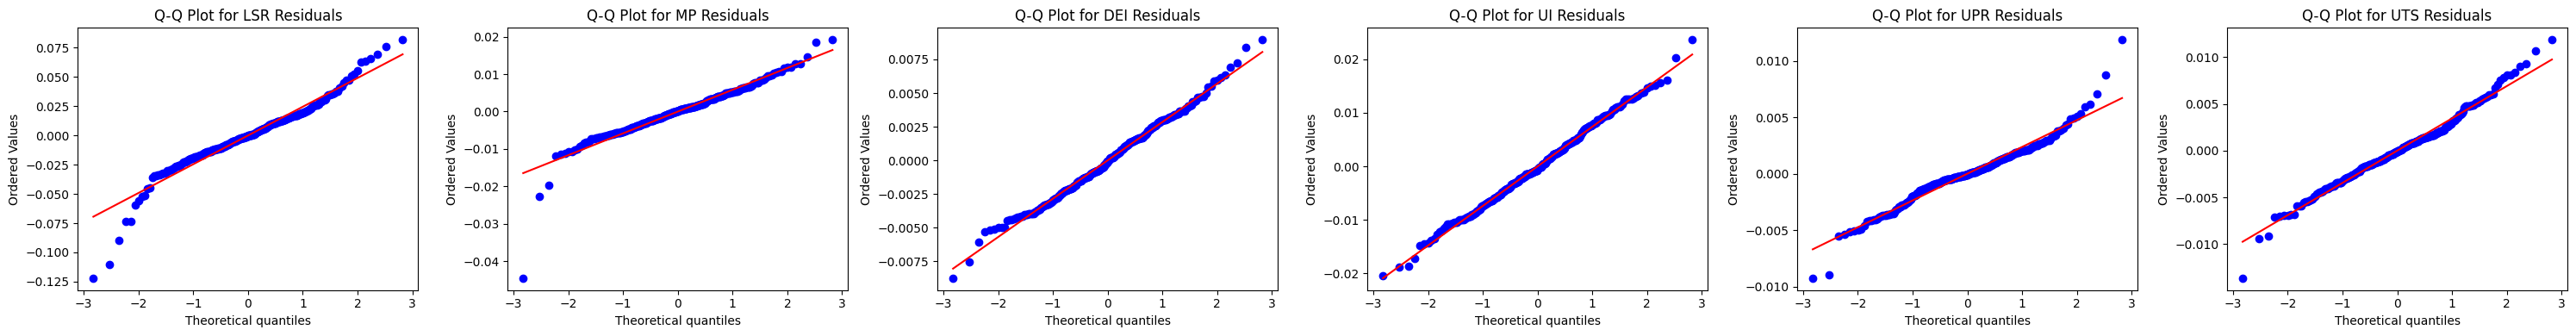


--- Plotting Autocorrelation Function of the First Column: LSR ---


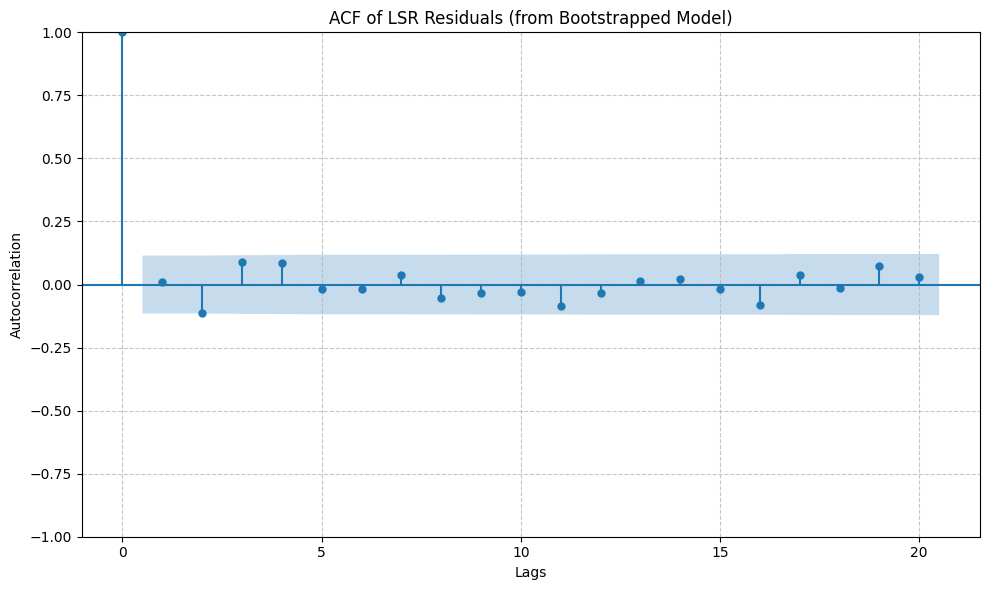

In [16]:
#Nomarlity Check for VAR Residuals
import statsmodels.stats.api as sms

# After fitting your VAR model (results object from above)
# Access residuals: results.resid (This is a pandas DataFrame)

bootstrapped_residuals = bootstrap_results['last_bootstrap_residuals']


# Jarque-Bera test for each residual series
for col in bootstrapped_residuals.columns:
    jb_test = sms.jarque_bera(results.resid[col])
    print(f"\nJarque-Bera Test for {col} residuals:")
    print(f"Statistic: {jb_test[0]:.4f}, P-value: {jb_test[1]:.4f}")
    print(f"Skewness: {jb_test[2]:.4f}, Kurtosis: {jb_test[3]:.4f}")

# You can also plot Q-Q plots for visual inspection:
import matplotlib.pyplot as plt
import scipy.stats as stats

fig, axes = plt.subplots(1, results.resid.shape[1], figsize=(5 * results.resid.shape[1], 4))
if results.resid.shape[1] == 1:
    axes = [axes] # Ensure axes is iterable even for a single series
for i, col in enumerate(results.resid.columns):
    stats.probplot(results.resid[col], dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q Plot for {col} Residuals')
plt.tight_layout()
plt.show()


if bootstrapped_residuals is not None and not bootstrapped_residuals.empty:
    # 1. Select the first column
    # You can select by index (0)
    first_column_data = bootstrapped_residuals.iloc[:, 0]
    first_column_name = bootstrapped_residuals.columns[0] # Get the name for the title

    print(f"\n--- Plotting Autocorrelation Function of the First Column: {first_column_name} ---")

    # 2. Create a single figure and a single subplot (Axes)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6)) # A single plot, adjust figsize as needed

    # 3. Plot ACF for the first column onto this single axis
    plot_acf(first_column_data, ax=ax, lags=20,
             title=f'ACF of {first_column_name} Residuals (from Bootstrapped Model)')
    ax.set_xlabel('Lags')
    ax.set_ylabel('Autocorrelation')
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout() # Adjusts subplot params for a tight layout
    plt.show()         # Displays the figure

else:
    print("No bootstrapped residuals available or DataFrame is empty to plot autocorrelation.")

The bootstrapped residuals are not normal. Since the undelying data is financial data this behaviour is expected. When using residual bootstrapping, the issue of non normal residuals does not occur anymore, as bootstrapping approximates the true distribution of the residuals without strict assumptions, which the VAR model requires. The model is now robust and valid for inference.


Running IRF Analysis for LSR

Impulse Response Results for LSR:
Shock           LSR                            MP                      \
Statistic       IRF Lower 95% Upper 95%       IRF Lower 95% Upper 95%   
Horizon                                                                 
0          1.000000  1.000000  1.000000  0.000000  0.000000  0.000000   
1          0.014697 -0.101424  0.130817 -0.055229 -0.084786 -0.025673   
2         -0.001085 -0.023655  0.021485 -0.003450 -0.010582  0.003681   
3          0.006260 -0.002565  0.015085  0.018774  0.016608  0.020941   
4          0.004185 -0.002979  0.011348  0.012889  0.011387  0.014391   
5          0.003564 -0.002729  0.009857  0.011365  0.010062  0.012668   
6          0.003173 -0.002394  0.008739  0.010069  0.008917  0.011221   
7          0.002784 -0.002146  0.007713  0.008829  0.007809  0.009849   
8          0.002443 -0.001927  0.006814  0.007751  0.006847  0.008655   
9          0.002145 -0.001734  0.006024  0.006806  0.006004

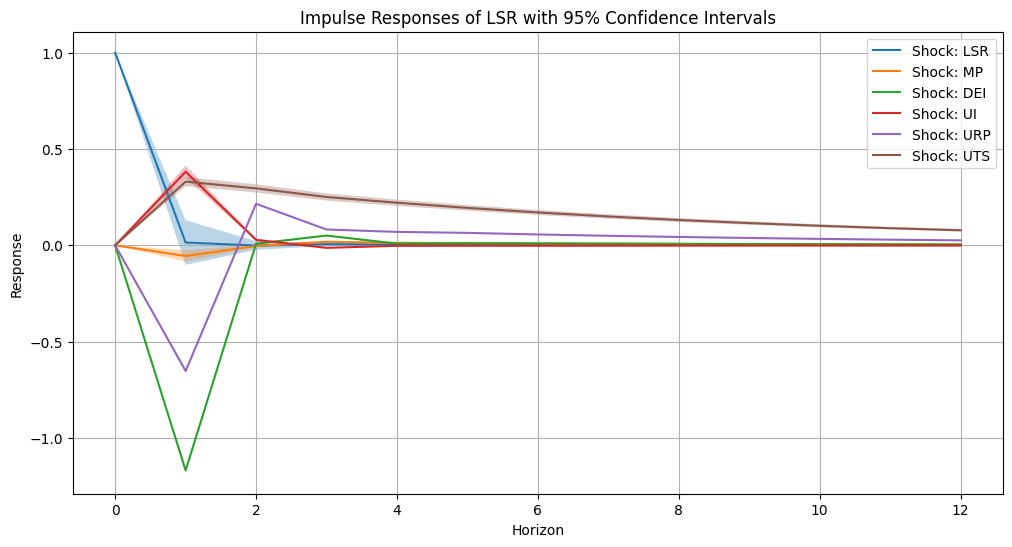

LaTeX table exported to lsr_irf_group1.tex
LaTeX table exported to lsr_irf_group2.tex

Running IRF Analysis for MIG

Impulse Response Results for Migration:
Shock     Migration                            MP                      \
Statistic       IRF Lower 95% Upper 95%       IRF Lower 95% Upper 95%   
Horizon                                                                 
0          1.000000  1.000000  1.000000  0.000000  0.000000  0.000000   
1          0.386588  0.277313  0.495864 -0.932736 -0.940878 -0.924595   
2          0.143864  0.059406  0.228322 -0.318684 -0.321820 -0.315548   
3          0.053946  0.005400  0.102493 -0.092699 -0.093966 -0.091432   
4          0.019878 -0.005054  0.044809 -0.021921 -0.022632 -0.021210   
5          0.006964 -0.005541  0.019469  0.004185  0.003653  0.004717   
6          0.002130 -0.004701  0.008962  0.012669  0.012219  0.013119   
7          0.000357 -0.004218  0.004932  0.014506  0.014113  0.014898   
8         -0.000261 -0.003921  0.003399 

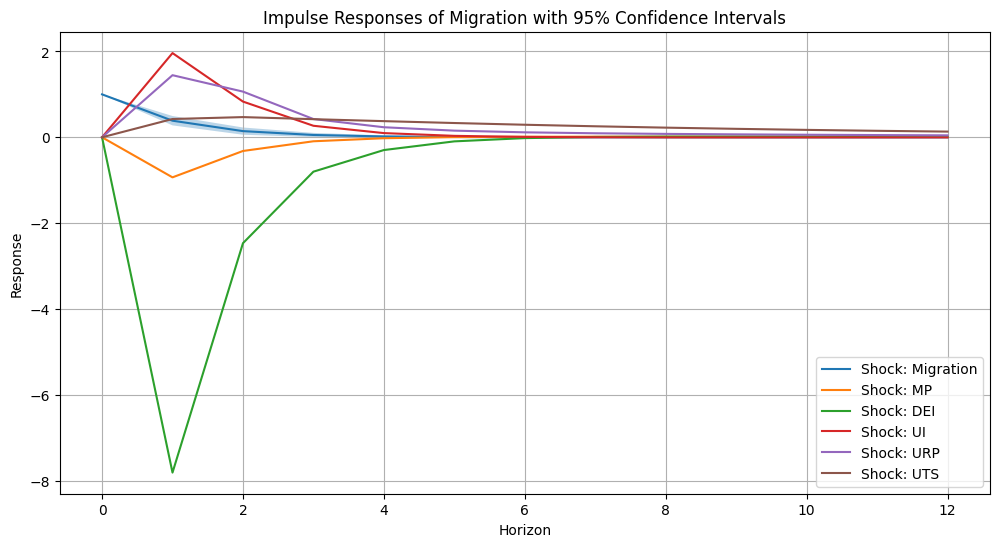

LaTeX table exported to mig_irf_group1.tex
LaTeX table exported to mig_irf_group2.tex

Running IRF Analysis for IY
Using first variable: Income Yield

Impulse Response Results for Income Yield:
Shock     Income Yield                            MP                      \
Statistic          IRF Lower 95% Upper 95%       IRF Lower 95% Upper 95%   
Horizon                                                                    
0             1.000000  1.000000  1.000000  0.000000  0.000000  0.000000   
1             0.511883  0.396121  0.627645  4.739579  4.737221  4.741937   
2             0.459854  0.360322  0.559386  4.327139  4.325309  4.328968   
3             0.340973  0.230526  0.451421  3.501170  3.499867  3.502473   
4             0.264877  0.150464  0.379289  2.191627  2.190518  2.192735   
5             0.202706  0.092140  0.313271  1.640457  1.639625  1.641290   
6             0.155117  0.051663  0.258570  1.205513  1.204863  1.206163   
7             0.118076  0.024184  0.211968  0.

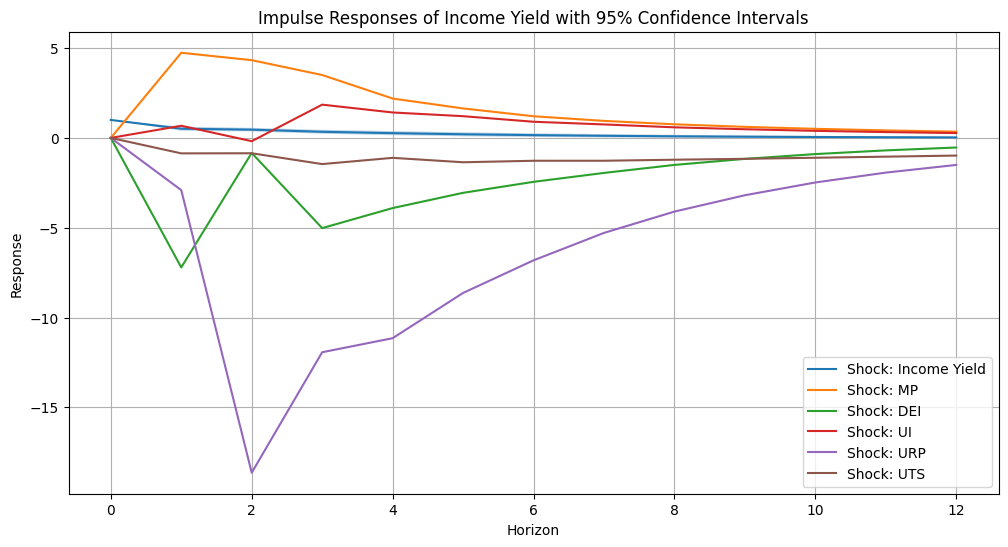

LaTeX table exported to iy_irf_group1.tex
LaTeX table exported to iy_irf_group2.tex

Running IRF Analysis for CAV
Using first variable: CAV

Impulse Response Results for CAV:
Shock           CAV                            MP                      \
Statistic       IRF Lower 95% Upper 95%       IRF Lower 95% Upper 95%   
Horizon                                                                 
0          1.000000  1.000000  1.000000  0.000000  0.000000  0.000000   
1          0.044667 -0.074544  0.163879  0.458901  0.449111  0.468691   
2          0.050622 -0.068577  0.169821  0.579970  0.569996  0.589943   
3          0.000680 -0.030276  0.031636  0.381610  0.378085  0.385136   
4         -0.001737 -0.021172  0.017698  0.104395  0.102358  0.106432   
5         -0.004659 -0.012816  0.003498  0.015146  0.014364  0.015927   
6         -0.002557 -0.008395  0.003280 -0.025619 -0.026136 -0.025102   
7         -0.001909 -0.006285  0.002467 -0.042710 -0.043088 -0.042332   
8         -0.001369 -0

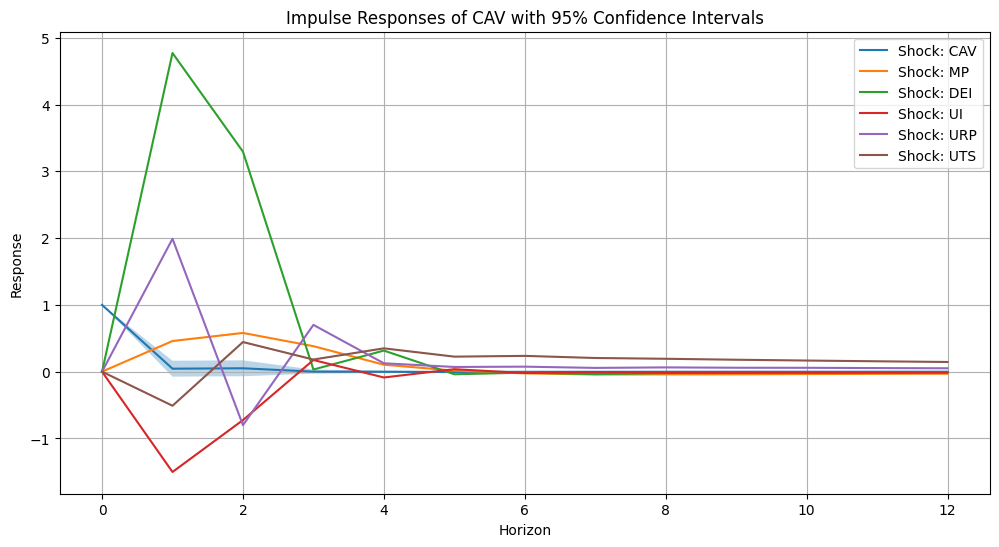

LaTeX table exported to cav_irf_group1.tex
LaTeX table exported to cav_irf_group2.tex

Impulse Response Results for LSR:
Shock           LSR                            MP                      \
Statistic       IRF Lower 95% Upper 95%       IRF Lower 95% Upper 95%   
Horizon                                                                 
0          1.000000  1.000000  1.000000  0.000000  0.000000  0.000000   
1          0.014697 -0.101424  0.130817 -0.055229 -0.084786 -0.025673   
2         -0.001085 -0.023655  0.021485 -0.003450 -0.010582  0.003681   
3          0.006260 -0.002565  0.015085  0.018774  0.016608  0.020941   
4          0.004185 -0.002979  0.011348  0.012889  0.011387  0.014391   
5          0.003564 -0.002729  0.009857  0.011365  0.010062  0.012668   
6          0.003173 -0.002394  0.008739  0.010069  0.008917  0.011221   
7          0.002784 -0.002146  0.007713  0.008829  0.007809  0.009849   
8          0.002443 -0.001927  0.006814  0.007751  0.006847  0.008655   
9  

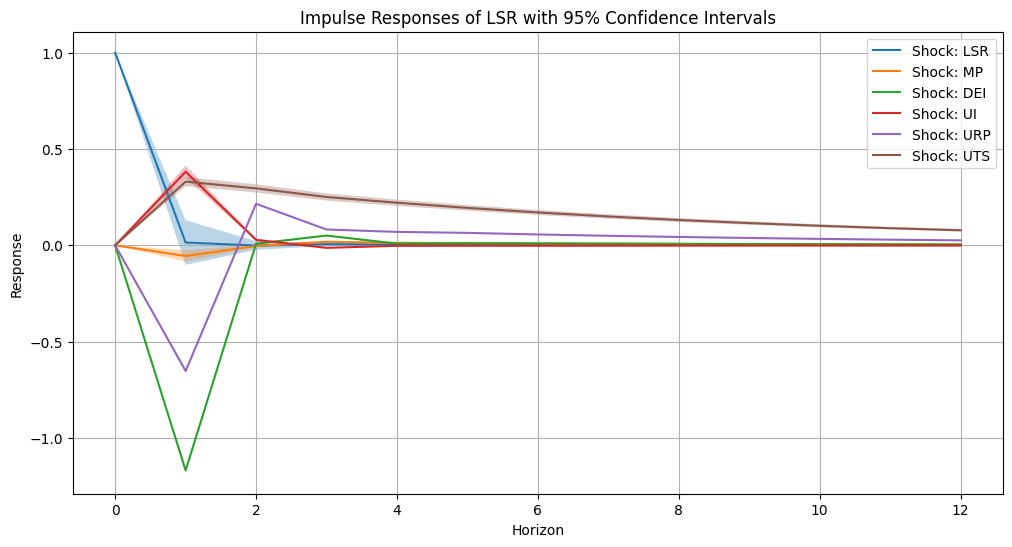


Impulse Response Results for Migration:
Shock     Migration                            MP                      \
Statistic       IRF Lower 95% Upper 95%       IRF Lower 95% Upper 95%   
Horizon                                                                 
0          1.000000  1.000000  1.000000  0.000000  0.000000  0.000000   
1          0.386588  0.277313  0.495864 -0.932736 -0.940878 -0.924595   
2          0.143864  0.059406  0.228322 -0.318684 -0.321820 -0.315548   
3          0.053946  0.005400  0.102493 -0.092699 -0.093966 -0.091432   
4          0.019878 -0.005054  0.044809 -0.021921 -0.022632 -0.021210   
5          0.006964 -0.005541  0.019469  0.004185  0.003653  0.004717   
6          0.002130 -0.004701  0.008962  0.012669  0.012219  0.013119   
7          0.000357 -0.004218  0.004932  0.014506  0.014113  0.014898   
8         -0.000261 -0.003921  0.003399  0.014003  0.013659  0.014347   
9         -0.000447 -0.003592  0.002699  0.012761  0.012459  0.013063   
10        

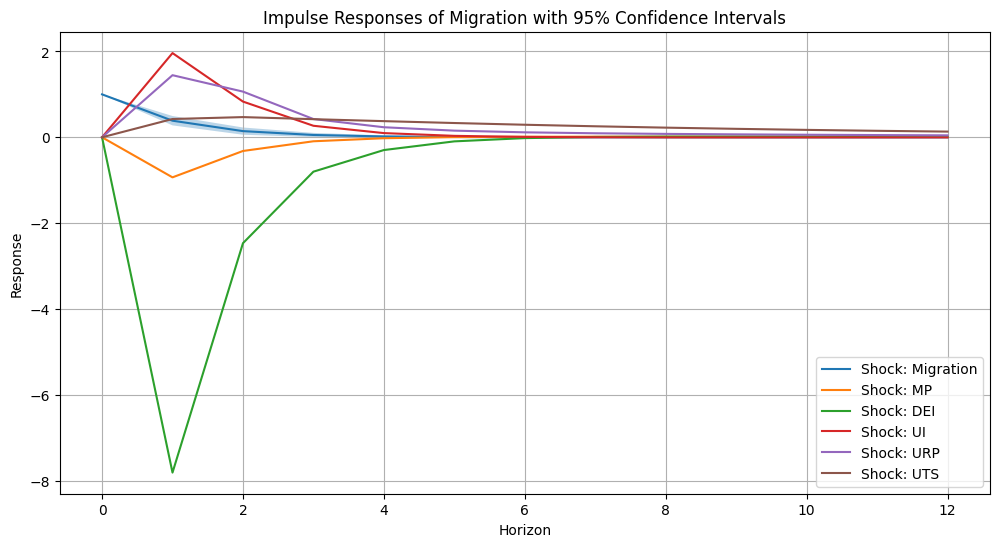

Using first variable: Income Yield

Impulse Response Results for Income Yield:
Shock     Income Yield                            MP                      \
Statistic          IRF Lower 95% Upper 95%       IRF Lower 95% Upper 95%   
Horizon                                                                    
0             1.000000  1.000000  1.000000  0.000000  0.000000  0.000000   
1             0.511883  0.396121  0.627645  4.739579  4.737221  4.741937   
2             0.459854  0.360322  0.559386  4.327139  4.325309  4.328968   
3             0.340973  0.230526  0.451421  3.501170  3.499867  3.502473   
4             0.264877  0.150464  0.379289  2.191627  2.190518  2.192735   
5             0.202706  0.092140  0.313271  1.640457  1.639625  1.641290   
6             0.155117  0.051663  0.258570  1.205513  1.204863  1.206163   
7             0.118076  0.024184  0.211968  0.946932  0.946420  0.947445   
8             0.089638  0.005934  0.173343  0.758062  0.757646  0.758479   
9        

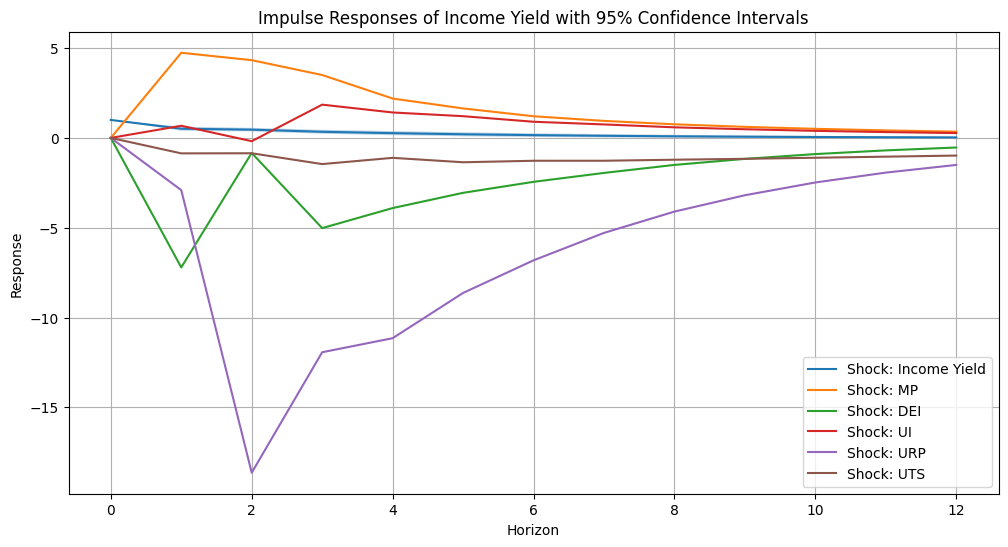

Using first variable: CAV

Impulse Response Results for CAV:
Shock           CAV                            MP                      \
Statistic       IRF Lower 95% Upper 95%       IRF Lower 95% Upper 95%   
Horizon                                                                 
0          1.000000  1.000000  1.000000  0.000000  0.000000  0.000000   
1          0.044667 -0.074544  0.163879  0.458901  0.449111  0.468691   
2          0.050622 -0.068577  0.169821  0.579970  0.569996  0.589943   
3          0.000680 -0.030276  0.031636  0.381610  0.378085  0.385136   
4         -0.001737 -0.021172  0.017698  0.104395  0.102358  0.106432   
5         -0.004659 -0.012816  0.003498  0.015146  0.014364  0.015927   
6         -0.002557 -0.008395  0.003280 -0.025619 -0.026136 -0.025102   
7         -0.001909 -0.006285  0.002467 -0.042710 -0.043088 -0.042332   
8         -0.001369 -0.005308  0.002569 -0.041148 -0.041458 -0.040837   
9         -0.001093 -0.004618  0.002432 -0.039629 -0.039902 -0.

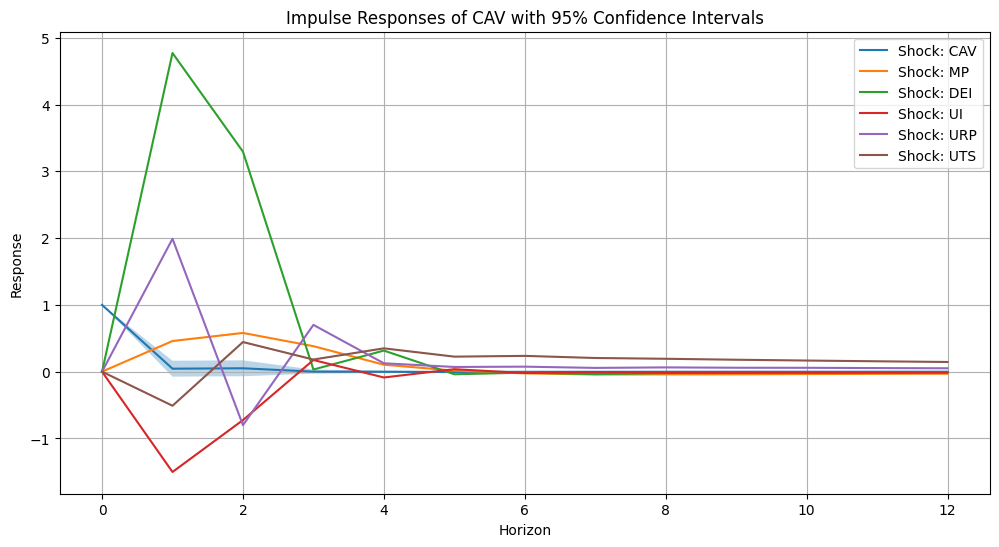

In [25]:
def bootstrap_irf(bootstrap_results, response_variable=None):
    """
    Bootstrap Impulse Response Function for any response variable
    
    Parameters:
    -----------
    bootstrap_results : dict
        Dictionary containing bootstrap_model
    response_variable : str, optional
        Name of the response variable. If None, uses first variable in the model
        
    Returns:
    --------
    tuple : (irf_df, first_df, second_df)
        IRF DataFrame and split tables for LaTeX export
    """
    bootstrap_irfs = bootstrap_results['bootstrap_model'].irf(12)
    irf_values = bootstrap_irfs.irfs
    
    # Get variable names
    variable_names = bootstrap_results['bootstrap_model'].names
    
    # Determine response variable index
    if response_variable is None:
        response_idx = 0
        response_var_name = variable_names[0]
        print(f"No response variable specified. Using first variable: {response_var_name}")
    else:
        if response_variable in variable_names:
            response_idx = variable_names.index(response_variable)
            response_var_name = response_variable
        else:
            print(f"Warning: {response_variable} not found in model variables {variable_names}")
            print(f"Using first variable: {variable_names[0]}")
            response_idx = 0
            response_var_name = variable_names[0]
    
    # Extract responses for the specified variable
    responses = irf_values[:, response_idx, :]
    
    horizon = irf_values.shape[0] - 1
    covmatrices = bootstrap_irfs.cov()
    n_vars = len(variable_names)
    
    # Calculate confidence intervals
    lower_bound = np.empty_like(responses)
    upper_bound = np.empty_like(responses)
    
    alpha = 0.05
    z = 1.96  # for ~95% CI
    
    for t in range(horizon + 1):
        covariance = covmatrices[t]  # shape (n_vars*n_vars, n_vars*n_vars)
        for j in range(n_vars):
            idx = response_idx * n_vars + j  # response variable, shock j
            se = np.sqrt(covariance[idx, idx])  # standard error
            lower_bound[t, j] = responses[t, j] - z * se
            upper_bound[t, j] = responses[t, j] + z * se
    
    # Create MultiIndex columns for response, shock, and bounds
    columns = pd.MultiIndex.from_product(
        [variable_names, ['IRF', 'Lower 95%', 'Upper 95%']],
        names=['Shock', 'Statistic']
    )
    
    # Create combined DataFrame
    data = np.empty((horizon + 1, n_vars * 3))
    for j in range(n_vars):
        data[:, j * 3] = responses[:, j]
        data[:, j * 3 + 1] = lower_bound[:, j]
        data[:, j * 3 + 2] = upper_bound[:, j]
    
    irf_df = pd.DataFrame(data, columns=columns)
    irf_df.index.name = 'Horizon'
    
    print(f"\nImpulse Response Results for {response_var_name}:")
    print(irf_df)
    
    # Plot results
    plt.figure(figsize=(12, 6))
    
    for j, shock_name in enumerate(variable_names):
        plt.plot(irf_df.index, irf_df[(shock_name, 'IRF')], 
                label=f'Shock: {shock_name}')
        plt.fill_between(
            irf_df.index,
            irf_df[(shock_name, 'Lower 95%')],
            irf_df[(shock_name, 'Upper 95%')],
            alpha=0.3
        )
    
    plt.title(f'Impulse Responses of {response_var_name} with 95% Confidence Intervals')
    plt.xlabel('Horizon')
    plt.ylabel('Response')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Prepare LaTeX export tables
    # Build MultiIndex columns for LaTeX export
    column_tuples = []
    for var in variable_names:
        column_tuples.extend([
            (var, 'IRF'),
            (var, 'Lower'),
            (var, 'Upper')
        ])
    latex_columns = pd.MultiIndex.from_tuples(column_tuples, names=["Shock", "Statistic"])
    
    # Fill the data row by row for each time horizon
    latex_data = []
    for t in range(horizon + 1):
        row = []
        for j in range(n_vars):
            row.extend([
                responses[t, j],
                lower_bound[t, j],
                upper_bound[t, j]
            ])
        latex_data.append(row)
    
    # Create the final DataFrame for LaTeX
    final_df = pd.DataFrame(latex_data, columns=latex_columns)
    final_df.insert(0, "Horizon", range(horizon + 1))
    
    # Get actual column tuples
    cols = final_df.columns.tolist()
    
    # Separate Horizon column (single level) from the others
    horizon_col = [col for col in cols if not isinstance(col, tuple)]
    irf_cols = [col for col in cols if isinstance(col, tuple)]
    
    # Define variable groups (adjust these as needed)
    mid_point = len(variable_names) // 2
    first_vars = variable_names[:mid_point] if len(variable_names) > 3 else variable_names[:3]
    second_vars = variable_names[mid_point:] if len(variable_names) > 3 else variable_names[3:]
    
    # Build correct column selections by checking what's available
    first_group_cols = [col for col in irf_cols if col[0] in first_vars]
    second_group_cols = [col for col in irf_cols if col[0] in second_vars]
    
    # Reconstruct DataFrames
    first_df = final_df[horizon_col + first_group_cols] if first_group_cols else final_df[horizon_col]
    second_df = final_df[horizon_col + second_group_cols] if second_group_cols else pd.DataFrame()
    
    return irf_df, first_df, second_df


def custom_latex_table(df, caption, label, filename):
    """
    Export DataFrame to LaTeX with custom caption and label
    """
    from io import StringIO
    
    if df.empty:
        print(f"Warning: DataFrame is empty for {filename}")
        return
    
    # Export initial LaTeX with multirow headers
    latex = df.to_latex(
        index=False,
        float_format="%.4f",
        multicolumn=True,
        multicolumn_format='c',
        longtable=True,
        escape=False
    )
    
    # Now inject caption and label manually into longtable structure
    latex_lines = latex.splitlines()
    
    # Identify the start of the longtable (where we will inject caption/label)
    start_idx = next(i for i, line in enumerate(latex_lines) if r'\begin{longtable}' in line)
    
    # Insert caption and label just after \begin{longtable}
    latex_lines.insert(start_idx + 1, f"\\caption{{{caption}}}\\\\")
    latex_lines.insert(start_idx + 2, f"\\label{{{label}}}\\\\")
    
    # Write to file
    with open(filename, "w") as f:
        f.write('\n'.join(latex_lines))
    
    print(f"LaTeX table exported to {filename}")


# Usage examples:
def run_all_irf_analyses(bootstrap_results_dict):
    """
    Run IRF analysis for all bootstrap results
    
    Parameters:
    -----------
    bootstrap_results_dict : dict
        Dictionary with keys like 'lsr', 'mig', 'iy', 'cav' and bootstrap results as values
    """
    
    # Define the response variables for each analysis
    variable_mapping = {
        'lsr': 'LSR',  # or None to use first variable
        'mig': 'Migration',  # adjust to your actual variable names
        'iy': 'Income_Yield',
        'cav': 'Change_Agg_Val'
    }
    
    results = {}
    
    for analysis_name, bootstrap_results in bootstrap_results_dict.items():
        print(f"\n{'='*60}")
        print(f"Running IRF Analysis for {analysis_name.upper()}")
        print(f"{'='*60}")
        
        # Get the appropriate response variable name
        response_var = variable_mapping.get(analysis_name, None)
        
        # Run IRF analysis
        irf_df, first_df, second_df = bootstrap_irf(bootstrap_results, response_variable=response_var)
        
        # Store results
        results[analysis_name] = {
            'irf_df': irf_df,
            'first_df': first_df,
            'second_df': second_df
        }
        
        # Export LaTeX tables
        if not first_df.empty:
            custom_latex_table(
                df=first_df,
                caption=f"Impulse Responses of {response_var or 'First Variable'} - Group 1",
                label=f"tab:{analysis_name}_irf_group1",
                filename=f"{analysis_name}_irf_group1.tex"
            )
        
        if not second_df.empty:
            custom_latex_table(
                df=second_df,
                caption=f"Impulse Responses of {response_var or 'First Variable'} - Group 2",
                label=f"tab:{analysis_name}_irf_group2",
                filename=f"{analysis_name}_irf_group2.tex"
            )
    
    return results

# Example usage:


bootstrap_results_dict = {
    'lsr': bootstrap_results,
    'mig': bootstrap_results_mig,
    'iy': bootstrap_results_iy,
    'cav': bootstrap_results_cav
}

# Run all analyses
all_results = run_all_irf_analyses(bootstrap_results_dict)

# Or run individual analyses:
bootstrap_irf_lsr, first_df_lsr, second_df_lsr = bootstrap_irf(bootstrap_results, 'LSR')
bootstrap_irf_mig, first_df_mig, second_df_mig = bootstrap_irf(bootstrap_results_mig, 'Migration')
bootstrap_irf_iy, first_df_iy, second_df_iy = bootstrap_irf(bootstrap_results_iy, 'Income_Yield')
bootstrap_irf_cav, first_df_cav, second_df_cav = bootstrap_irf(bootstrap_results_cav, 'Change_Agg_Val')


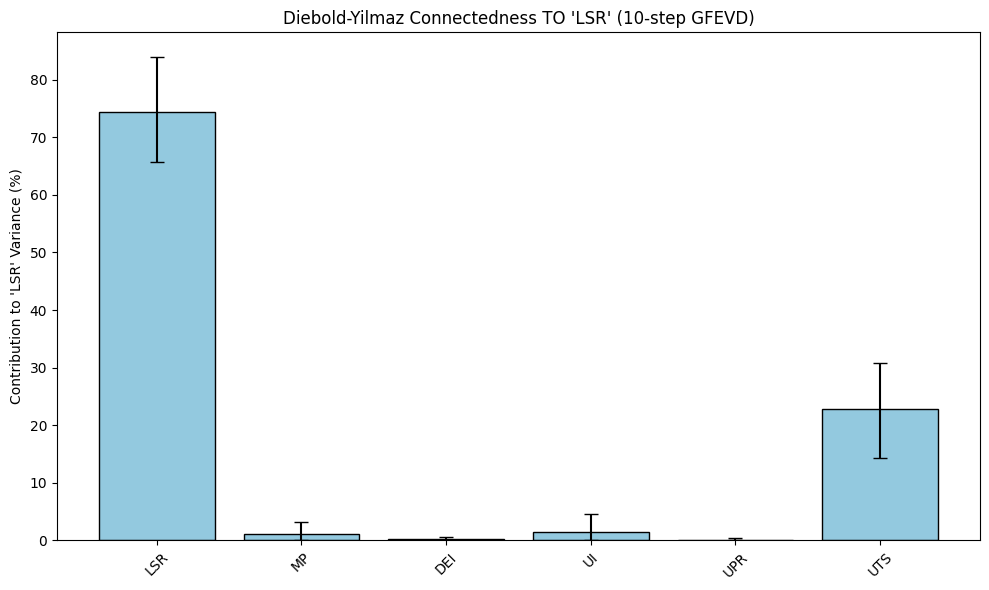

In [18]:
#Connectedness measures from Diebold-Yildiz (2014)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

gfevd_bootstrap = []



def compute_gfevd(var_result, horizon=10):
    """
    Compute Generalized Forecast Error Variance Decomposition (GFEVD)
    Based on Pesaran & Shin (1998)
    """
    sigma_u = var_result.sigma_u  # residual covariance matrix
    Phi = var_result.ma_rep(maxn=horizon)  # MA coefficient matrices

    K = sigma_u.shape[0]
    fevd = np.zeros((K, K))  # [dependent_var, shock_var]

    for j in range(K):  # for each shock
        ej = np.zeros(K)
        ej[j] = 1.0
        for h in range(horizon):
            phi_h = Phi[h]
            num = (phi_h @ sigma_u @ ej) ** 2
            den = np.diag(phi_h @ sigma_u @ phi_h.T)
            fevd[:, j] += num / den

    # Normalize rows to sum to 1
    fevd_normalized = fevd / fevd.sum(axis=1)[:, None]
    return fevd_normalized

for fit in bootstrap_results['bootstrap_fits']:
    try:
        g = compute_gfevd(fit, horizon=10)
        gfevd_bootstrap.append(g)
    except Exception as e:
        continue

ls_ret_index = fit.names.index('LSR')
ls_ret_contribs = [g[ls_ret_index] for g in gfevd_bootstrap]
ls_ret_contribs = np.array(ls_ret_contribs)  # shape: (n_bootstrap, n_vars)

mean_contrib = np.mean(ls_ret_contribs, axis=0)
ci_lower = np.percentile(ls_ret_contribs, 2.5, axis=0)
ci_upper = np.percentile(ls_ret_contribs, 97.5, axis=0)

labels = fit.names

plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=mean_contrib*100, color='skyblue', edgecolor='k')
plt.errorbar(x=np.arange(len(labels)), y=mean_contrib*100,
             yerr=[(mean_contrib - ci_lower)*100, (ci_upper - mean_contrib)*100],
             fmt='none', ecolor='black', capsize=5)
plt.ylabel("Contribution to 'LSR' Variance (%)")
plt.title("Diebold-Yilmaz Connectedness TO 'LSR' (10-step GFEVD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
